# YOLO Object Detection Model Training with Ultralytics

The Ultralytics Pytorch framework is used to train a YOLOv8 pre-trained model using SAR SLC imagery converted from complex64 numpy arrays to uint8 PNG format.

The orginal training dataset comprises 3114 pixel crops (96 x 96 pixels) from 40 full size SAR SLC scenes which were processed using the method described in Section 5, SARFish_Project_Part_1 Jupyter notebook. The validation and test sets consist of 463 and 253 image crops, respectively, processed in the same manner. 

## 1. Setup

In [2]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

In [3]:
# Set up data paths
%matplotlib inline
import sys
from pathlib import Path

# Get to project root from notebook location
PROJECT_ROOT = Path.cwd().parent
# Add "src" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "src"))

# Define project paths
DATA_DIR = PROJECT_ROOT / "data"
CONFIG_DIR = PROJECT_ROOT / "configs"
RUNS_DIR = PROJECT_ROOT / "runs" 

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR:     {DATA_DIR}")
print(f"CONFIG_DIR:   {CONFIG_DIR}")
print(f"RUNS_DIR:     {RUNS_DIR}")

PROJECT_ROOT: /home/peterm/UWA/CITS5014/SARFish/modelling
DATA_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/data
CONFIG_DIR:   /home/peterm/UWA/CITS5014/SARFish/modelling/configs
RUNS_DIR:     /home/peterm/UWA/CITS5014/SARFish/modelling/runs


In [4]:
# Complete SAR Dataset Conversion Script
#import torch
#import numpy as np
#import cv2

from datetime import datetime
#import shutil
import yaml
#from tqdm import tqdm
from ultralytics import YOLO
from plot_loss_curves import plot_total_loss

## 2. Model Inspection (YOLOv8)

In [11]:
#%run {PROJECT_ROOT / 'src/yolov8n_model_explorer'}

### Proposed Freezing Strategies:

For YOLOv8n fine-tuning on SAR data:

1. CONSERVATIVE (Freeze backbone only):  
   Freezes modules 0-9
   - Freezes: 1,272,656 parameters (40.3%)
   - Trains: 1,884,544 parameters (59.7%)  
2. MODERATE (Freeze backbone + early neck):  
   Freezes modules 0-12  
3. AGGRESSIVE (Freeze most, train detection head only):  
   Freezes modules 0-20

## 3. Model training

The models used here exclusively use the 'alternative' processing datesert, i.e. where the immage arrays have shape=(96, 96, 3), mode=RGB and dtype=uint8. The 'RGB' channels are comprised of Red: clipped (99% coverage), dB-scaled and normalised amplitude; Green: normalised phase and Blue: zeros channel, respectively.

In [5]:
# Enable TensorBoard logging
#!yolo settings tensorboard=True

In [4]:
%load_ext tensorboard
%tensorboard --logdir /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs

### 3.1 No augmentation, imbalanced dataset (3:1)

Create the data .yaml configuration file:

In [8]:
# Create data configuration used by both single and dual-phase training
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_no_aug.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [10]:
# Load the model
model = YOLO('yolov8n.pt')

In [12]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_no_aug',
    name=timestamp,
    
    # Augmentation parameters (nullified)
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.0, 
    scale=0.0, 
    fliplr=0.0, 
    mosaic=0.0
)

New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_no_aug.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, multi_scale=

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_alt/labels... 3114 images, 0 backgrounds, 0 corru

train: New cache created: /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_alt/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.5±4.4 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels... 463 images, 0 backgrounds, 0 corrupt: 1

val: New cache created: /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels.cache


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_no_aug/20250815_2204/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_no_aug/20250815_2204
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.29G      2.323      4.091      2.145         10        640: 100%|██████████| 195/195 [00:36<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<


                   all        463        463      0.323      0.398       0.23     0.0656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.54G      1.719       2.09      1.598         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        463        463       0.68      0.147      0.173     0.0484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.56G      1.636      1.636      1.547         10        640: 100%|██████████| 195/195 [00:50<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.241      0.517      0.313      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.57G      1.557      1.512      1.504         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.292      0.467      0.354      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.59G      1.505      1.447      1.475         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.219       0.41      0.275     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.61G      1.449        1.4      1.434         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.261      0.413        0.3      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.63G      1.429       1.35      1.431         10        640: 100%|██████████| 195/195 [01:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.241      0.466      0.277     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.63G      1.393      1.332      1.404         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.271      0.499      0.332      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.66G      1.352      1.295      1.395         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.232      0.496       0.29     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.68G      1.317       1.25      1.359         10        640: 100%|██████████| 195/195 [01:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.304      0.485       0.33      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.69G      1.282      1.193      1.342         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.318      0.426      0.339      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.7G       1.26      1.172      1.326         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.315      0.427      0.328      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.73G        1.2      1.113       1.29         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.239      0.436      0.299      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.75G      1.171      1.073      1.264         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463        0.3      0.405      0.285        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.76G      1.134      1.023      1.243         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.254      0.416      0.286     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.77G      1.091     0.9602      1.211         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.308      0.347      0.275     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.8G      1.061      0.927      1.191         10        640: 100%|██████████| 195/195 [01:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.369      0.416      0.338      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.81G     0.9965     0.8588      1.147         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.281      0.417      0.275     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.83G     0.9757     0.8211      1.133         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.291       0.41        0.3        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.84G     0.9185     0.7596      1.098         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.324      0.394      0.295     0.0949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.87G      0.888      0.723       1.08         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.267       0.43      0.272     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.88G     0.8461     0.6792      1.057         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.352      0.339      0.288      0.093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.9G     0.8139     0.6418      1.039         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.289      0.354      0.266     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.91G     0.7723     0.6066      1.017         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.272      0.413      0.277     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.93G     0.7205     0.5516     0.9875         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463       0.28       0.33      0.253     0.0759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.95G     0.7032     0.5294     0.9797         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.295      0.378      0.284     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.97G     0.6709     0.5118     0.9639         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.281      0.386       0.26     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.97G     0.6369     0.4892     0.9478         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.308       0.35      0.269     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         3G     0.5986     0.4632     0.9317         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.313       0.34      0.274     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.02G     0.5779     0.4439     0.9181         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.337      0.246      0.238     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.04G     0.5422     0.4192     0.9039         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.401       0.29      0.275     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.04G     0.5223     0.4066     0.8984         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.29       0.35      0.265     0.0794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.07G     0.4913     0.3856     0.8836         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.325      0.364      0.275     0.0807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.09G     0.4642     0.3738     0.8736         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.347      0.393      0.285     0.0839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.1G     0.4503     0.3624     0.8688         10        640: 100%|██████████| 195/195 [01:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.27      0.427      0.276     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.11G     0.4326     0.3511     0.8621         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.322      0.364      0.268     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.14G      0.403     0.3289     0.8504         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.313      0.341      0.274     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.15G     0.3833     0.3197       0.84         10        640: 100%|██████████| 195/195 [01:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.284      0.406      0.257     0.0783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.17G     0.3736     0.3142     0.8382         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.312      0.351       0.28     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.18G     0.3559     0.2998     0.8313         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.347      0.377      0.286     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.21G     0.3441      0.292     0.8287         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.334      0.347      0.288     0.0892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.22G     0.3361     0.2829     0.8226         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.305      0.423      0.298     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.24G     0.3168     0.2719     0.8163         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.311      0.342       0.28     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.25G     0.3064     0.2643     0.8123         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.367      0.361      0.296     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.28G     0.2999     0.2596     0.8094         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.32      0.383      0.282     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.29G     0.2899     0.2507     0.8078         10        640: 100%|██████████| 195/195 [00:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.315      0.392       0.29      0.093



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.31G     0.2707     0.2405     0.8013         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.311      0.392      0.288     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.32G     0.2659     0.2332     0.7978         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.362      0.343      0.286     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.34G     0.2607     0.2288     0.7969         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.352      0.345      0.284     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.36G     0.2566     0.2274     0.7955         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.357      0.321      0.267     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.38G     0.2468     0.2177     0.7915         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.308      0.349      0.272     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.38G     0.2457     0.2173     0.7925         10        640: 100%|██████████| 195/195 [00:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.328      0.362      0.282     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.41G     0.2387     0.2114     0.7883         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.34      0.368      0.277     0.0811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.43G     0.2344     0.2088     0.7849         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.306      0.386      0.271     0.0823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.45G      0.224     0.2003     0.7824         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.284      0.421      0.279     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.45G     0.2125     0.1928     0.7788         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.287      0.399      0.279     0.0836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.48G     0.2043     0.1864      0.778         10        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.309      0.377      0.283     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       3.5G     0.2094     0.1889     0.7783         10        640: 100%|██████████| 195/195 [00:38<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.299      0.431      0.282     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.51G     0.1994     0.1811     0.7761         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.32      0.377      0.283     0.0884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.52G     0.1978     0.1788     0.7741         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.342      0.333      0.274     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.55G     0.1969     0.1804     0.7747         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.341      0.322      0.274     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.56G     0.1949     0.1745      0.774         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.331      0.336      0.276     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.58G     0.1955     0.1789      0.773         10        640: 100%|██████████| 195/195 [00:40<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.325      0.363      0.286     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.59G      0.189      0.173     0.7709         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.303      0.367      0.273     0.0821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.62G     0.1803     0.1662     0.7699         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.272      0.369      0.267     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.63G      0.182     0.1657     0.7684         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.335      0.342      0.272     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.65G     0.1745      0.162     0.7663         10        640: 100%|██████████| 195/195 [00:41<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.321      0.383      0.285     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.66G      0.174     0.1609     0.7671         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.331      0.353      0.288     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.69G     0.1682     0.1552      0.765         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.317      0.383      0.293     0.0899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       3.7G     0.1598     0.1485     0.7623         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.34       0.34      0.283     0.0852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.72G     0.1647     0.1521     0.7647         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.346      0.351      0.291      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.73G     0.1567     0.1458     0.7624         10        640: 100%|██████████| 195/195 [01:02<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.341      0.319      0.288     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.75G     0.1509     0.1438       0.76         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.318      0.367       0.29     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.77G     0.1557      0.146     0.7621         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.338      0.379      0.285     0.0849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.79G     0.1499     0.1405     0.7599         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.338      0.378      0.291     0.0888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.79G     0.1477     0.1413      0.763         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.35      0.362       0.29     0.0876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.82G     0.1419     0.1341     0.7589         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.391      0.336      0.297     0.0874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.84G     0.1389     0.1334     0.7589         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.282      0.361      0.266     0.0818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.86G      0.136     0.1326     0.7567         10        640: 100%|██████████| 195/195 [00:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.32      0.373      0.277     0.0821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.86G     0.1334     0.1305     0.7566         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.306      0.357      0.272     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.89G     0.1309      0.127     0.7567         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.324      0.373      0.286      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.91G     0.1317     0.1277     0.7597         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.319      0.381      0.285     0.0839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.92G     0.1273     0.1256     0.7568         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.35      0.338      0.278     0.0842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.93G      0.128     0.1248     0.7574         10        640: 100%|██████████| 195/195 [00:53<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.298      0.368      0.285     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.96G      0.122     0.1205      0.756         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.342      0.356      0.284     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.97G     0.1192     0.1178     0.7531         10        640: 100%|██████████| 195/195 [01:03<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.321      0.338      0.272     0.0833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.99G     0.1146     0.1136     0.7527         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.313      0.399      0.286     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         4G     0.1157     0.1139      0.754         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.325      0.373      0.275     0.0819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.91G     0.1123     0.1109     0.7531         10        640: 100%|██████████| 195/195 [01:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.322      0.351      0.281     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.91G     0.1133     0.1117     0.7561         10        640: 100%|██████████| 195/195 [00:50<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.323      0.338      0.282     0.0856


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.91G     0.1061     0.1062     0.7538         10        640: 100%|██████████| 195/195 [00:35<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        463        463      0.306      0.357      0.277     0.0841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.91G     0.1018     0.1054     0.7514         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.304      0.363      0.275     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.91G    0.09737    0.09993     0.7506         10        640: 100%|██████████| 195/195 [01:00<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.315      0.342      0.277     0.0847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.91G    0.09915     0.1012     0.7525         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.317      0.357      0.273     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.91G    0.09541    0.09861     0.7521         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.317      0.355      0.275     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.91G    0.09138    0.09526     0.7495         10        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463       0.32      0.351      0.278     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.91G    0.08699    0.09213      0.748         10        640: 100%|██████████| 195/195 [00:57<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.337      0.347      0.279     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.91G    0.08557    0.08902     0.7499         10        640: 100%|██████████| 195/195 [01:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.339      0.348      0.277     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.91G    0.08177    0.08605     0.7492         10        640: 100%|██████████| 195/195 [00:35<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.349      0.339      0.277     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.91G    0.08489    0.08861     0.7511         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.334      0.347      0.276      0.086



100 epochs completed in 1.858 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_no_aug/20250815_2204/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_no_aug/20250815_2204/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_no_aug/20250815_2204/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<


                   all        463        463      0.295      0.474      0.354      0.126
             is_vessel        331        331      0.272      0.577      0.451      0.173
            is_fishing        132        132      0.318      0.371      0.258     0.0792
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_no_aug/20250815_2204


In [26]:
results_path = RUNS_DIR / 'png_runs'/ 'png_no_aug' / '20250815_2204'

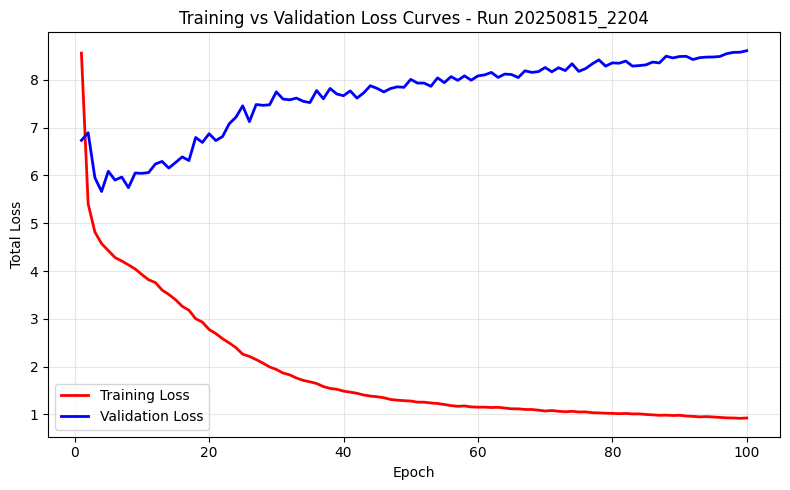

In [27]:
plot_total_loss(str(results_path / 'results.csv'))

### 3.2 Augmentation,  imbalanced dataset (3:1)

#### 3.2.1 In situ (hvrt)

Create the data .yaml configuration file:

In [10]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [11]:
# Load the model
model = YOLO('yolov8n.pt')

In [12]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug',
    name=timestamp,
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # transaltion (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=0.0
)

New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, multi_scale=Fa

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_alt/labels.cache... 3114 images, 0 backgrounds, 0


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 42.3±10.7 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels.cache... 463 images, 0 backgrounds, 0 corr


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0000/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0000
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.94G      2.219      3.875      2.075         10        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.717      0.236      0.285      0.095



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.27G       1.85      2.246      1.695         10        640: 100%|██████████| 195/195 [00:35<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        463        463      0.686       0.13      0.154     0.0553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.29G      1.753      1.809      1.651         10        640: 100%|██████████| 195/195 [00:41<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.217      0.482      0.295      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.29G      1.715      1.665      1.603         10        640: 100%|██████████| 195/195 [01:05<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.271      0.338      0.294      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.32G       1.66      1.622      1.563         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.227      0.484      0.303      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.34G      1.622      1.588      1.524         10        640: 100%|██████████| 195/195 [00:36<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.316      0.557      0.375      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.35G      1.597      1.549      1.514         10        640: 100%|██████████| 195/195 [00:42<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.347      0.443      0.372      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.35G      1.575      1.525      1.505         10        640: 100%|██████████| 195/195 [01:05<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.308      0.539      0.386      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.35G       1.58      1.513      1.505         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.285      0.528      0.385      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.35G      1.556      1.507      1.484         10        640: 100%|██████████| 195/195 [00:54<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.243      0.636      0.365      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.35G      1.534        1.5      1.482         10        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.371      0.541      0.426      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.35G      1.516      1.464      1.476         10        640: 100%|██████████| 195/195 [00:38<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.348      0.653       0.45      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.35G      1.518      1.458      1.479         10        640: 100%|██████████| 195/195 [01:05<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.318      0.674      0.495      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.35G      1.504      1.472      1.467         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.317      0.567       0.41      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.35G      1.479      1.438      1.447         10        640: 100%|██████████| 195/195 [00:36<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.301      0.605      0.427      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.35G      1.467      1.444      1.454         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.393      0.547      0.444      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.35G      1.462      1.433      1.439         10        640: 100%|██████████| 195/195 [00:50<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.38      0.577      0.451      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.35G      1.458      1.438      1.434         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.357      0.581      0.439      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.35G      1.459      1.425      1.438         10        640: 100%|██████████| 195/195 [01:03<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.349      0.595      0.472      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.35G      1.444      1.416      1.419         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.281      0.647      0.424      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.35G      1.437      1.395      1.417         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.353      0.587      0.457       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.35G      1.433        1.4      1.421         10        640: 100%|██████████| 195/195 [00:51<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.442      0.529      0.487        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.35G      1.426      1.399       1.42         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.352      0.547      0.456      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.35G      1.422      1.395      1.415         10        640: 100%|██████████| 195/195 [00:59<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.363      0.564      0.471      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.35G      1.418      1.384      1.414         10        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.382      0.642      0.525      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.35G      1.401      1.373      1.403         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.409      0.632      0.507      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.35G      1.426      1.382      1.417         10        640: 100%|██████████| 195/195 [00:42<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.492      0.564      0.525      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.35G      1.413      1.373      1.404         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.389      0.565        0.5      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.35G      1.398      1.372      1.406         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.415      0.525      0.501      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.35G      1.403      1.373      1.402         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.403      0.634      0.533      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.35G      1.396      1.362      1.394         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.411      0.647      0.531      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.35G      1.383      1.371      1.397         10        640: 100%|██████████| 195/195 [00:50<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.37      0.641       0.54      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.35G       1.39      1.369       1.39         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.414        0.6      0.512      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.35G      1.375      1.357      1.389         10        640: 100%|██████████| 195/195 [00:55<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.443      0.579      0.515      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.35G      1.382       1.36      1.392         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.404      0.682      0.529      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.35G      1.364      1.364      1.373         10        640: 100%|██████████| 195/195 [00:37<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.387      0.584      0.482      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.35G      1.364      1.333      1.382         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.41      0.617      0.526      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.35G      1.368      1.339      1.385         10        640: 100%|██████████| 195/195 [01:03<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.376      0.637      0.507       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.35G       1.36      1.339       1.38         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.395      0.686      0.521      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.35G      1.349       1.34      1.366         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.405      0.669      0.528       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.35G      1.357      1.321      1.368         10        640: 100%|██████████| 195/195 [00:48<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.392      0.671      0.514      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.35G      1.361      1.341      1.379         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.374      0.655      0.509      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.35G      1.351      1.323      1.367         10        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.408      0.663      0.525      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.35G      1.335      1.331      1.361         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.482      0.559      0.542      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.35G      1.346      1.328      1.372         10        640: 100%|██████████| 195/195 [00:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.48      0.618      0.559      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.35G      1.344       1.31       1.37         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.435      0.676      0.523      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.35G      1.349      1.316      1.376         10        640: 100%|██████████| 195/195 [00:45<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.473      0.576      0.562      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.35G      1.331      1.316      1.361         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.449      0.628      0.537      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.35G      1.325      1.304      1.358         10        640: 100%|██████████| 195/195 [00:42<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.425      0.583       0.52      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.35G       1.32      1.305      1.348         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.47      0.632       0.57      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.35G      1.328      1.299       1.36         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.412      0.609      0.522      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.35G       1.33      1.305      1.357         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463       0.42       0.66      0.553      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.35G      1.324      1.297      1.358         10        640: 100%|██████████| 195/195 [00:45<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.447      0.639       0.54      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.35G      1.314      1.297      1.353         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.429       0.66      0.532      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.35G      1.318      1.282       1.35         10        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.446      0.614      0.531      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.35G      1.316      1.285      1.346         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.412      0.588      0.501      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.35G      1.301      1.279      1.337         10        640: 100%|██████████| 195/195 [00:42<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.475      0.614      0.538      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.35G      1.303      1.278      1.339         10        640: 100%|██████████| 195/195 [01:05<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.463      0.638       0.54      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.35G      1.312      1.277      1.343         10        640: 100%|██████████| 195/195 [00:42<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.424      0.626      0.517      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.35G      1.302      1.284      1.336         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.456      0.628      0.521      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.35G      1.298      1.268       1.34         10        640: 100%|██████████| 195/195 [00:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.472      0.644      0.551      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.35G      1.299      1.266      1.341         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.436      0.647      0.497      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.35G      1.303      1.258      1.338         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.456      0.682      0.529      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.35G      1.299      1.257      1.332         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.477      0.622      0.541      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.35G      1.276      1.259       1.33         10        640: 100%|██████████| 195/195 [00:41<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463       0.46      0.642      0.523      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.35G      1.284      1.247      1.328         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.477      0.652      0.536      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.35G      1.285      1.255      1.328         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.461      0.641      0.532       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.35G      1.284      1.235      1.324         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.475      0.616      0.555      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.35G       1.28      1.243      1.321         10        640: 100%|██████████| 195/195 [00:37<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.486      0.684      0.571      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.35G      1.275      1.233      1.324         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.473      0.603      0.566      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.35G      1.269      1.237      1.321         10        640: 100%|██████████| 195/195 [00:37<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.484      0.616       0.56      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.35G      1.275      1.226      1.314         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.455      0.663      0.554      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.35G      1.268      1.227      1.319         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.476      0.633      0.569      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.35G      1.262       1.21      1.317         10        640: 100%|██████████| 195/195 [00:54<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.481      0.659      0.563      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.35G      1.257      1.209      1.319         10        640: 100%|██████████| 195/195 [01:03<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463        0.5      0.649      0.551      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.35G      1.252       1.22      1.316         10        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.497      0.628      0.565      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.35G      1.259      1.212      1.313         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.483      0.647      0.541      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.35G      1.256      1.202      1.304         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.49      0.636      0.548      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.35G      1.252      1.204      1.306         10        640: 100%|██████████| 195/195 [00:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.503      0.605      0.555      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.35G      1.246      1.195      1.302         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.475      0.619      0.551       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.35G      1.239      1.189        1.3         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.467      0.643      0.552      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.35G      1.246      1.177        1.3         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.488      0.609      0.545      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.35G      1.241       1.19      1.307         10        640: 100%|██████████| 195/195 [00:43<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.494      0.629      0.556      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.35G      1.244      1.193      1.303         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.463      0.632      0.546      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.35G      1.237      1.176      1.302         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.473      0.608      0.557      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.35G      1.231      1.171      1.293         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.469      0.622      0.545      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.35G      1.226      1.172      1.293         10        640: 100%|██████████| 195/195 [00:36<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.486      0.625      0.556      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.35G      1.229      1.172      1.285         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.501        0.6      0.572      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.35G      1.209      1.163      1.282         10        640: 100%|██████████| 195/195 [00:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.508      0.615       0.57      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.35G      1.216      1.162      1.284         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.483      0.632       0.57      0.258


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.35G      1.217      1.158      1.286         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.468      0.632      0.552      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.35G      1.204      1.153      1.278         10        640: 100%|██████████| 195/195 [00:38<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.476      0.617      0.545      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.35G      1.202       1.15      1.273         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.477      0.629      0.547      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.35G      1.197      1.141       1.27         10        640: 100%|██████████| 195/195 [00:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.489      0.622      0.548      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.35G      1.202      1.148      1.276         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.483      0.607      0.552      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.35G        1.2      1.143      1.277         10        640: 100%|██████████| 195/195 [00:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.476      0.601      0.551      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.35G      1.199      1.137      1.274         10        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.444      0.647      0.546      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.35G      1.191      1.136      1.271         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.468      0.638      0.551      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.35G       1.19      1.131      1.268         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.469      0.639      0.553      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.35G      1.192      1.136      1.267         10        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463       0.46      0.629      0.544       0.25



100 epochs completed in 1.404 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0000/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0000/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0000/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        463        463      0.507      0.615       0.57      0.258
             is_vessel        331        331      0.597      0.722      0.748      0.359
            is_fishing        132        132      0.416      0.508      0.392      0.157
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0000


In [28]:
results_path = RUNS_DIR / 'png_runs'/ 'png_aug' / '20250816_0000'

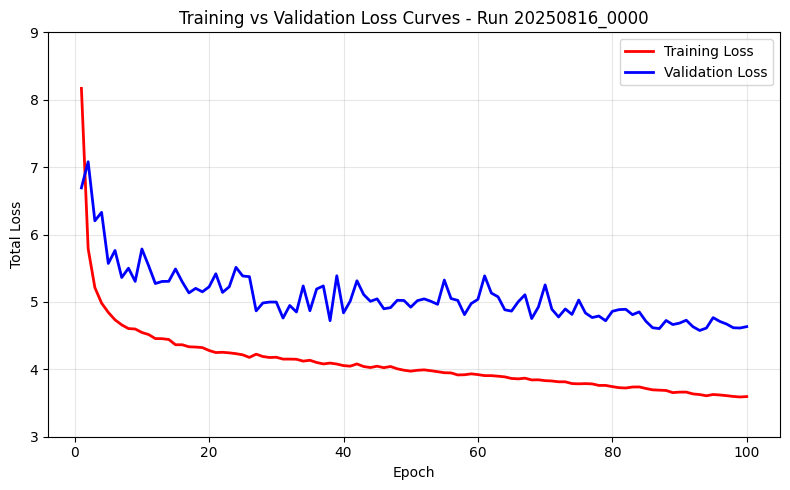

In [29]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

#### 3.2.2 In situ (hvrt + mosaic)

Note: Uses same data .yaml file as above

In [15]:
# Load the model
model = YOLO('yolov8n.pt')

In [16]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug',
    name=timestamp,
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # transaltion (+/- fraction)
    degrees=15.0,    # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0
)

New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=Fa

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_alt/labels.cache... 3114 images, 0 backgrounds, 0

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 337.5±213.3 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels.cache... 463 images, 0 backgrounds, 0 corr


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0124/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0124
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.06G      2.293      3.828      2.251         18        640: 100%|██████████| 195/195 [00:36<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        463        463     0.0698     0.0438     0.0365     0.0086

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.37G      2.102      2.559      2.013         15        640: 100%|██████████| 195/195 [00:35<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.192      0.236       0.14     0.0336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.38G      2.029      2.154      1.946         14        640: 100%|██████████| 195/195 [01:05<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.706      0.204      0.216     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.38G      1.986      2.057      1.925         14        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.257      0.426      0.302     0.0941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.41G      1.932      1.985      1.873         16        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.172      0.381      0.212     0.0682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.41G       1.89      1.904      1.849         13        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.774      0.248      0.289     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.41G      1.838      1.855      1.805         14        640: 100%|██████████| 195/195 [00:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.182      0.509      0.308      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.41G      1.809      1.794      1.756         13        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.313      0.588      0.395      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.41G      1.766      1.746      1.723         14        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.268      0.539      0.383      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.41G      1.784      1.748      1.734         16        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.243      0.337      0.242     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.41G      1.755      1.729      1.728         15        640: 100%|██████████| 195/195 [00:38<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.316      0.492        0.4      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.41G      1.742      1.747      1.706         13        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.386      0.562      0.466      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.42G      1.716      1.704      1.687         16        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.372      0.459       0.42      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.42G      1.685      1.682      1.652         13        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.361      0.605      0.485      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.42G      1.666      1.672      1.645         13        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.321       0.57      0.424      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.42G      1.648      1.643      1.651         15        640: 100%|██████████| 195/195 [00:40<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.369      0.542      0.443       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.42G      1.624       1.64      1.611         15        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.407      0.537      0.455      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.42G      1.635      1.641      1.628         16        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.415      0.541      0.485      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.42G       1.59      1.616      1.601         18        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.409      0.521      0.487      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.42G      1.578      1.581      1.593         15        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.384      0.383      0.374      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.42G      1.594      1.597      1.607         13        640: 100%|██████████| 195/195 [00:40<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.412      0.508      0.434      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.42G      1.569      1.582      1.593         13        640: 100%|██████████| 195/195 [01:05<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.355      0.621       0.49      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.42G      1.577      1.586      1.594         14        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.338      0.704      0.487      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.42G      1.538      1.595      1.569         12        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.374      0.596      0.479      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.42G      1.543      1.588       1.57         16        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.371      0.584      0.498      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.42G      1.513      1.566      1.558         16        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.414      0.485      0.492      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.42G      1.534      1.581      1.559         13        640: 100%|██████████| 195/195 [01:05<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.544      0.507      0.505      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.42G      1.528      1.559      1.567         13        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463       0.34       0.59      0.483      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.42G      1.522      1.575      1.556         14        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.454      0.461      0.463      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.42G      1.482       1.54       1.54         13        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.393      0.588      0.471      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.42G      1.491      1.541      1.533         14        640: 100%|██████████| 195/195 [00:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.413      0.509      0.501       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.42G       1.49       1.53       1.54         12        640: 100%|██████████| 195/195 [01:00<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.399      0.517      0.486      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.44G      1.473       1.53      1.524         12        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.421      0.481      0.444      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.44G       1.48      1.537      1.526         12        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.412      0.507      0.484      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.44G      1.467      1.521      1.518         16        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.366      0.603      0.486      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.44G      1.478      1.533       1.52         14        640: 100%|██████████| 195/195 [00:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.329      0.649      0.481      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.44G      1.456      1.512      1.521         15        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.47      0.552       0.53      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.44G      1.447       1.51      1.509         14        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.508      0.526      0.534      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.44G      1.438      1.504      1.504         16        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.508      0.558      0.565      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.44G      1.471      1.523      1.527         14        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.424      0.572      0.512       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.44G       1.43      1.506      1.497         15        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.441      0.542      0.517       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.44G      1.447      1.494      1.514         17        640: 100%|██████████| 195/195 [00:45<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.444      0.535      0.517      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.44G       1.42      1.489      1.505         15        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.458      0.554      0.509      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.44G      1.418      1.497      1.498         12        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.576      0.518      0.566      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.44G      1.434      1.516      1.493         14        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.417       0.52      0.533      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.44G      1.431      1.492      1.497         13        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.518      0.567      0.534      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.44G      1.419       1.49      1.498         14        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.482      0.543      0.521      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.44G        1.4      1.463      1.478         13        640: 100%|██████████| 195/195 [00:41<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.453      0.607      0.559      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.44G      1.402       1.49      1.493         13        640: 100%|██████████| 195/195 [01:02<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.484      0.521      0.521      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.44G      1.409      1.482      1.491         15        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.449      0.541      0.521      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.44G      1.417      1.488      1.479         14        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.498      0.527      0.532      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.44G      1.404      1.468      1.485         14        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.442      0.597      0.556      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.44G      1.403      1.459       1.48         18        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.492      0.525      0.499      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.44G      1.398      1.465      1.465         14        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.448      0.609      0.539      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.44G      1.397       1.48      1.477         15        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.482      0.576      0.583      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.44G      1.371      1.465      1.465         17        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463        0.5       0.55      0.547      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.44G      1.383      1.469      1.472         15        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.486      0.552      0.553      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.44G      1.381       1.47      1.474         16        640: 100%|██████████| 195/195 [00:35<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.479      0.609      0.584      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.44G      1.395      1.465      1.483         15        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.418      0.645      0.543      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.44G      1.363      1.448      1.463         14        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.436      0.574      0.533      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.44G      1.373      1.446      1.465         14        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.435      0.566      0.555      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.44G      1.377      1.466      1.473         15        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.482      0.529      0.545      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.44G      1.364       1.45      1.467         14        640: 100%|██████████| 195/195 [00:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<


                   all        463        463       0.42      0.574      0.523      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.44G      1.359       1.44      1.451         16        640: 100%|██████████| 195/195 [01:00<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.453      0.633      0.579      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.44G      1.371      1.433       1.46         16        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.408      0.577      0.543      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.44G      1.367      1.446      1.464         14        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.466      0.606      0.572       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.44G      1.362      1.446      1.453         15        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.453      0.551      0.548       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.44G      1.349      1.437      1.449         14        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.456      0.584      0.559      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.44G      1.355      1.434      1.462         17        640: 100%|██████████| 195/195 [00:39<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.463      0.642      0.563      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.44G      1.345      1.438       1.44         18        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.493       0.61      0.543      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.44G      1.343      1.451      1.438         14        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.428      0.626      0.551      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.44G      1.336      1.436      1.443         13        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.483      0.613      0.569      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.44G      1.347      1.433       1.45         13        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.489      0.613       0.58      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.44G      1.335      1.422      1.442         15        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.438       0.62      0.558       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.44G      1.332      1.428      1.441         16        640: 100%|██████████| 195/195 [00:45<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.439      0.624      0.554      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.44G      1.344      1.421      1.447         18        640: 100%|██████████| 195/195 [00:53<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.47      0.588      0.566      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.44G      1.325       1.41      1.427         15        640: 100%|██████████| 195/195 [00:31<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.497      0.561       0.58      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.44G       1.33      1.417      1.445         17        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.459      0.613      0.555      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.44G      1.329        1.4      1.439         17        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.484      0.555      0.562      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.44G      1.308      1.425      1.434         13        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.428      0.618      0.571      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.44G      1.316      1.418      1.433         13        640: 100%|██████████| 195/195 [00:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<


                   all        463        463      0.464      0.589      0.571      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.44G      1.309      1.405      1.418         13        640: 100%|██████████| 195/195 [01:03<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.472      0.591      0.554      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.44G      1.311      1.413      1.433         12        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.486      0.652      0.579      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.44G      1.298      1.406      1.426         11        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.463      0.597      0.569      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.44G      1.309      1.414      1.422         16        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.478      0.618      0.578      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.44G       1.31      1.399      1.425         16        640: 100%|██████████| 195/195 [00:32<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.497      0.643      0.602      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.44G      1.305      1.401      1.429         12        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.487      0.591      0.574      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.44G      1.306      1.397      1.426         15        640: 100%|██████████| 195/195 [01:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.483      0.626      0.587      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.44G      1.302      1.395      1.421         13        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.513       0.57      0.577      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.44G      1.309      1.397      1.422         15        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.496      0.615      0.577      0.265


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.44G      1.303      1.274       1.41         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.512      0.589      0.572      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.44G      1.288       1.27      1.401         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.504      0.591      0.576      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.44G      1.274      1.263      1.393         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.506      0.588      0.582      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.44G      1.276      1.257      1.392         10        640: 100%|██████████| 195/195 [00:48<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.49      0.578      0.583      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.44G      1.268      1.251      1.391         10        640: 100%|██████████| 195/195 [00:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.482      0.595      0.579       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.44G      1.275      1.251      1.394         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.517      0.583      0.583      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.44G      1.268      1.253      1.388         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463        0.5      0.612      0.578      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.44G      1.266      1.247      1.389         10        640: 100%|██████████| 195/195 [00:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.503      0.602      0.576      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.44G      1.264      1.252      1.385         10        640: 100%|██████████| 195/195 [00:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463       0.51      0.612      0.577      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.44G      1.263      1.248      1.383         10        640: 100%|██████████| 195/195 [00:41<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.502        0.6      0.578       0.26



100 epochs completed in 1.236 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0124/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0124/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0124/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.493       0.64      0.602      0.276
             is_vessel        331        331      0.551      0.749      0.753      0.361
            is_fishing        132        132      0.435       0.53      0.451       0.19
Speed: 0.4ms preprocess, 5.8ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug/20250816_0124


In [30]:
results_path = RUNS_DIR / 'png_runs' / 'png_aug' / '20250816_0124'

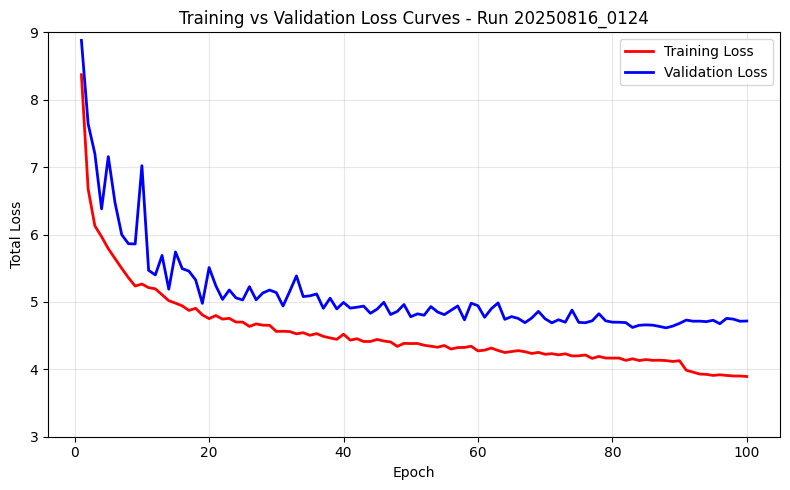

In [31]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

### 3.3 Augmentation, Balanced dataset

#### 3.3.1 Pre-augmented (hvrt) + in situ (hvrt)

**SGD** auto-selected here. Up until now, **AdamW** was auto-selected.

Create the data .yaml configuration file:

In [10]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_bal_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_bal.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [36]:
# Load the model
model = YOLO('yolov8n.pt')
model.add_callback('on_train_batch_end', sar_amplitude_visualization)

In [37]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug_bal',
    name=timestamp,
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # transaltion (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=0.0
)

New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug_bal.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.0, multi_scal

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_hvrt_bal_alt/labels... 7559 images, 0 backgrounds

train: New cache created: /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_hvrt_bal_alt/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 32.2±8.5 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels.cache... 463 images, 0 backgrounds, 0 corr


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250816_1025/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250816_1025
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.23G      2.287      4.203      2.137          7        640: 100%|██████████| 473/473 [01:43<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<


                   all        463        463      0.323      0.509      0.322      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.23G      1.921      2.334      1.672          7        640: 100%|██████████| 473/473 [01:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        463        463      0.164      0.496      0.202     0.0603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.23G      1.916       1.88      1.742          7        640: 100%|██████████| 473/473 [01:30<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.279      0.454      0.296     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.23G      1.874      1.735      1.754          7        640: 100%|██████████| 473/473 [01:27<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.257      0.613       0.32      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.23G      1.791      1.654       1.71          7        640: 100%|██████████| 473/473 [01:29<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.296      0.617       0.37      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.23G      1.747      1.612      1.702          7        640: 100%|██████████| 473/473 [02:02<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.235      0.485      0.374      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.23G      1.701      1.579      1.677          7        640: 100%|██████████| 473/473 [01:20<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.337       0.54      0.411      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.23G      1.682      1.558      1.664          7        640: 100%|██████████| 473/473 [01:50<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.415      0.507      0.426      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.24G      1.641      1.533      1.637          7        640: 100%|██████████| 473/473 [01:20<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.361      0.624      0.486      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.24G      1.629      1.528      1.645          7        640: 100%|██████████| 473/473 [01:30<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.404      0.582       0.48      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.24G      1.613      1.509      1.632          7        640: 100%|██████████| 473/473 [01:49<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.352      0.645      0.442      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.24G      1.602      1.491      1.626          7        640: 100%|██████████| 473/473 [01:31<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.433      0.536      0.502      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.24G      1.591      1.486      1.626          7        640: 100%|██████████| 473/473 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.38      0.622       0.53      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.24G       1.57      1.472      1.606          7        640: 100%|██████████| 473/473 [01:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.505      0.561      0.524       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.25G      1.563      1.473      1.605          7        640: 100%|██████████| 473/473 [01:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.323      0.657      0.521      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.25G      1.553      1.456      1.597          7        640: 100%|██████████| 473/473 [01:28<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.465      0.605      0.495      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.25G      1.537      1.456      1.588          7        640: 100%|██████████| 473/473 [02:01<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.417      0.557        0.5      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.25G      1.535      1.445      1.573          7        640: 100%|██████████| 473/473 [01:28<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.439      0.561      0.518      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.25G      1.535      1.433      1.582          7        640: 100%|██████████| 473/473 [01:58<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.426      0.554      0.497      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.25G      1.518      1.425      1.566          7        640: 100%|██████████| 473/473 [01:23<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.415       0.66      0.508      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.25G      1.518      1.416      1.565          7        640: 100%|██████████| 473/473 [02:06<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.451      0.573      0.543      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.25G      1.497      1.418      1.553          7        640: 100%|██████████| 473/473 [01:24<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.474       0.57      0.529      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.25G        1.5      1.409      1.556          7        640: 100%|██████████| 473/473 [02:28<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.431      0.531      0.491      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.25G      1.491      1.406      1.542          7        640: 100%|██████████| 473/473 [01:24<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.401      0.658      0.518      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.25G      1.492      1.397      1.556          7        640: 100%|██████████| 473/473 [02:38<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.489      0.623      0.533      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.25G      1.471      1.387      1.532          7        640: 100%|██████████| 473/473 [01:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.419      0.591      0.528      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.25G      1.471      1.393      1.543          7        640: 100%|██████████| 473/473 [02:37<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.464      0.629      0.532      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.25G      1.466      1.391      1.534          7        640: 100%|██████████| 473/473 [01:30<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.498      0.592      0.562      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.25G      1.458      1.376      1.528          7        640: 100%|██████████| 473/473 [02:39<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.47       0.56      0.508      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.25G      1.455       1.38      1.523          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.455      0.566      0.534      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.25G      1.452      1.363      1.526          7        640: 100%|██████████| 473/473 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.401      0.654       0.54      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.25G      1.448      1.366      1.524          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.531      0.558      0.548      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.25G      1.445      1.358      1.515          7        640: 100%|██████████| 473/473 [01:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.494      0.602      0.555      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.25G      1.442      1.353       1.51          7        640: 100%|██████████| 473/473 [02:39<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.491      0.625      0.548      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.25G      1.435      1.353      1.506          7        640: 100%|██████████| 473/473 [02:38<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.456       0.62      0.546      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.25G      1.428      1.342      1.498          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.494       0.61      0.564      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.25G      1.424      1.341       1.49          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.477      0.615       0.55      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.25G      1.413      1.336      1.476          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.475      0.611      0.552      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.25G      1.413      1.321      1.488          7        640: 100%|██████████| 473/473 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.463      0.636      0.523      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.25G      1.409      1.314      1.479          7        640: 100%|██████████| 473/473 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.468      0.617      0.557      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.25G      1.415      1.305      1.484          7        640: 100%|██████████| 473/473 [01:36<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.469      0.659      0.543      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.25G      1.402       1.31       1.48          7        640: 100%|██████████| 473/473 [02:39<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.529      0.626      0.548      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.26G      1.392      1.305      1.472          7        640: 100%|██████████| 473/473 [01:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.509      0.593      0.551      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.26G      1.399      1.294      1.471          7        640: 100%|██████████| 473/473 [02:40<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.505      0.582      0.565       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.26G      1.392      1.284      1.473          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.474      0.607      0.544      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.26G      1.387      1.282      1.462          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.476      0.605      0.544      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.26G      1.376       1.27      1.459          7        640: 100%|██████████| 473/473 [01:42<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463        0.5      0.616      0.556      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.26G      1.379      1.268      1.461          7        640: 100%|██████████| 473/473 [02:38<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.505      0.597      0.556      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.26G      1.373      1.259      1.456          7        640: 100%|██████████| 473/473 [02:40<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.502      0.612      0.567      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.26G      1.362      1.259       1.45          7        640: 100%|██████████| 473/473 [02:39<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.507      0.622      0.575      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.26G      1.362      1.246      1.443          7        640: 100%|██████████| 473/473 [02:39<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.533      0.629      0.574      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.26G      1.351      1.242      1.439          7        640: 100%|██████████| 473/473 [02:38<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.496      0.603      0.556      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.26G      1.345      1.235      1.434          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.531      0.592      0.554       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.26G      1.348      1.224       1.43          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.512      0.633      0.558      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.26G       1.35      1.214      1.432          7        640: 100%|██████████| 473/473 [01:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.501      0.582      0.554       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.26G       1.34        1.2       1.43          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.524      0.584      0.572      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.26G      1.329      1.201      1.421          7        640: 100%|██████████| 473/473 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.512      0.597      0.546      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.26G      1.329      1.192      1.416          7        640: 100%|██████████| 473/473 [02:38<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.515       0.59      0.549       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.26G      1.322      1.177      1.413          7        640: 100%|██████████| 473/473 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.522      0.592      0.537      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.26G      1.312       1.17      1.404          7        640: 100%|██████████| 473/473 [01:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.51      0.646      0.549      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.26G      1.315      1.159      1.405          7        640: 100%|██████████| 473/473 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.539      0.599      0.567      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.26G      1.314      1.151      1.402          7        640: 100%|██████████| 473/473 [01:37<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.539       0.59      0.557      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.26G      1.306      1.139      1.398          7        640: 100%|██████████| 473/473 [02:35<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.539      0.628      0.571      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.26G      1.296       1.13      1.393          7        640: 100%|██████████| 473/473 [01:24<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.538      0.614      0.569      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.26G       1.29      1.123      1.387          7        640: 100%|██████████| 473/473 [02:27<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.581       0.57      0.578      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.26G       1.29      1.117      1.389          7        640: 100%|██████████| 473/473 [01:34<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.569      0.603      0.567      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.26G      1.283      1.106      1.382          7        640: 100%|██████████| 473/473 [02:14<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.56      0.576      0.553      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.26G      1.283      1.101      1.376          7        640: 100%|██████████| 473/473 [01:45<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.607      0.554      0.582      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.26G      1.268      1.089      1.368          7        640: 100%|██████████| 473/473 [01:51<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.568      0.584      0.561      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.26G      1.268      1.073       1.37          7        640: 100%|██████████| 473/473 [02:06<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.623      0.576      0.594      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.26G      1.252      1.067      1.363          7        640: 100%|██████████| 473/473 [01:32<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.622      0.576      0.593      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.26G      1.246       1.05      1.361          7        640: 100%|██████████| 473/473 [02:15<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.604      0.605      0.588      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.26G      1.243      1.044      1.352          7        640: 100%|██████████| 473/473 [01:31<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.611      0.613       0.58      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.26G      1.235      1.042      1.348          7        640: 100%|██████████| 473/473 [02:05<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.578      0.616      0.573      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.26G      1.229      1.016      1.344          7        640: 100%|██████████| 473/473 [01:49<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.613      0.598      0.588      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.26G      1.218      1.003      1.339          7        640: 100%|██████████| 473/473 [01:43<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.593      0.603       0.59      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.26G      1.221     0.9977      1.339          7        640: 100%|██████████| 473/473 [02:02<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.586      0.613      0.594      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.26G      1.209      0.992      1.333          7        640: 100%|██████████| 473/473 [01:29<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.611      0.585      0.595      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.26G      1.205     0.9841      1.326          7        640: 100%|██████████| 473/473 [02:13<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.564      0.615      0.582      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.26G        1.2     0.9671      1.323          7        640: 100%|██████████| 473/473 [01:25<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.595      0.586      0.566      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.26G       1.19     0.9612      1.313          7        640: 100%|██████████| 473/473 [02:01<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.594      0.563      0.574      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.26G      1.182     0.9509      1.311          7        640: 100%|██████████| 473/473 [01:48<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.615      0.554      0.564      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.26G      1.178     0.9417      1.308          7        640: 100%|██████████| 473/473 [01:40<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.596      0.568      0.562       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.26G      1.175      0.925        1.3          7        640: 100%|██████████| 473/473 [02:06<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.602      0.562      0.567      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.26G      1.162     0.9172      1.294          7        640: 100%|██████████| 473/473 [01:19<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.611      0.564      0.568      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.26G      1.157     0.9036       1.29          7        640: 100%|██████████| 473/473 [02:15<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.584      0.588      0.571      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.26G      1.147     0.9002      1.288          7        640: 100%|██████████| 473/473 [01:24<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.57      0.594      0.568      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.26G       1.14     0.8854      1.279          7        640: 100%|██████████| 473/473 [02:10<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.579      0.607      0.574      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.26G      1.132     0.8721      1.277          7        640: 100%|██████████| 473/473 [01:34<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.59      0.577      0.565      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.26G      1.129     0.8686      1.274          7        640: 100%|██████████| 473/473 [02:00<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.563      0.604      0.564       0.25


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.26G      1.116     0.8668      1.265          7        640: 100%|██████████| 473/473 [01:50<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.571      0.603      0.567      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.26G      1.117     0.8496      1.265          7        640: 100%|██████████| 473/473 [01:38<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.555      0.616      0.564      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.26G      1.105     0.8484      1.258          7        640: 100%|██████████| 473/473 [02:03<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.547      0.639      0.563      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.26G      1.102     0.8373      1.255          7        640: 100%|██████████| 473/473 [01:18<00:00,  6
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.557      0.637      0.564      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.26G      1.087     0.8235      1.246          7        640: 100%|██████████| 473/473 [02:18<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.55      0.621       0.56      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.26G      1.081     0.8195      1.242          7        640: 100%|██████████| 473/473 [01:21<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.563      0.615      0.569      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.26G      1.077     0.8197      1.238          7        640: 100%|██████████| 473/473 [02:09<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.581      0.588      0.571      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.26G      1.073      0.802       1.24          7        640: 100%|██████████| 473/473 [01:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.589      0.585      0.568      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.26G       1.07     0.7991      1.234          7        640: 100%|██████████| 473/473 [01:43<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.583      0.587      0.567      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.26G      1.063     0.7959       1.23          7        640: 100%|██████████| 473/473 [02:04<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.58      0.586      0.568      0.246



100 epochs completed in 3.528 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250816_1025/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250816_1025/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250816_1025/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        463        463      0.593      0.587      0.593      0.272
             is_vessel        331        331      0.736       0.64      0.751      0.372
            is_fishing        132        132      0.451      0.534      0.436      0.173
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250816_1025


In [32]:
results_path = RUNS_DIR / 'png_runs' / 'png_aug_bal' / '20250816_1025'

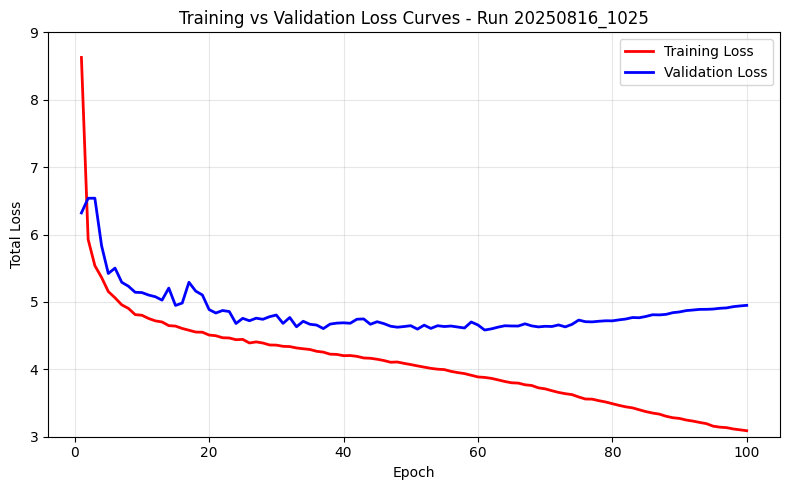

In [33]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

#### 3.3.2 Pre-augmented (hvrt) + in situ (hvrt + mosaic)

Note: 
- Uses same data .yaml file as above
- Explicitly uses **SGD** as optimizer

In [ ]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_bal_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_bal.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [11]:
# Load the model
model = YOLO('yolov8n.pt')

In [12]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug_bal',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # transaltion (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

New https://pypi.org/project/ultralytics/8.3.179 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug_bal.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=1.0, multi_scale=

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_hvrt_bal_alt/labels... 7559 images, 0 backgrounds


train: New cache created: /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_hvrt_bal_alt/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1318.6±687.7 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels... 463 images, 0 backgrounds, 0 corrupt: 1

val: New cache created: /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels.cache


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250817_2350/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250817_2350
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.97G      2.317      3.421      2.213         11        640: 100%|██████████| 473/473 [01:57<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.275      0.381      0.237     0.0607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.29G      2.093      2.308      1.964          8        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.203      0.309      0.139     0.0351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.29G      2.069      2.161      1.909         10        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.337      0.382       0.24     0.0712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.3G      2.024      2.088      1.887         12        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.417      0.461      0.372      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.32G      1.986      1.988      1.875          9        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.378      0.472      0.416      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.33G      1.939      1.925      1.839         10        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.354      0.503      0.341      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.34G      1.892      1.882      1.814          7        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.378      0.408      0.363      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.34G      1.872      1.869      1.789          9        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.263      0.514      0.349      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.36G      1.858      1.823      1.785          9        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.258       0.53      0.369      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.38G      1.838       1.81      1.764          9        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.431      0.549       0.48      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.39G      1.813      1.782      1.741         11        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.396       0.55      0.458      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.39G      1.798      1.767      1.711          8        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.352      0.605      0.448      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.41G      1.795      1.751      1.718          9        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.339      0.581      0.457       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.42G       1.75      1.722      1.692          9        640: 100%|██████████| 473/473 [01:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.413      0.519      0.495      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.43G      1.746      1.725      1.704          7        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.35      0.613      0.487      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.43G      1.733      1.704      1.679          9        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.436      0.527      0.465        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.46G      1.722      1.693      1.658         11        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.359      0.634      0.453      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.47G      1.709      1.686      1.672         12        640: 100%|██████████| 473/473 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.392       0.56      0.503      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.48G      1.697      1.688      1.638          9        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.498      0.569      0.512       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.48G      1.678      1.683      1.637         12        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.435      0.609      0.511      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.5G       1.68      1.676      1.637          8        640: 100%|██████████| 473/473 [01:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.395       0.58      0.459      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.51G      1.678      1.655      1.626         11        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.481      0.581      0.509      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.52G      1.653       1.64      1.617          9        640: 100%|██████████| 473/473 [01:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.435      0.606      0.514      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.53G      1.654      1.652      1.624          9        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.369      0.609      0.486       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.55G      1.642      1.628      1.605          6        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.416      0.657      0.503      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.56G       1.65      1.634      1.619         11        640: 100%|██████████| 473/473 [01:33<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.378      0.618      0.452      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.57G      1.637      1.622      1.604         12        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.468      0.557      0.526      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.57G      1.633      1.616      1.598          9        640: 100%|██████████| 473/473 [01:50<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.395      0.569      0.505      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.59G      1.619      1.606       1.59          8        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.53       0.55      0.531      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.6G      1.619      1.617      1.584         11        640: 100%|██████████| 473/473 [01:43<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.474      0.577      0.537      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.62G      1.613      1.609       1.59          9        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.447      0.584      0.532      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.62G      1.601      1.609      1.576         13        640: 100%|██████████| 473/473 [01:50<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.468      0.616      0.531      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.64G      1.597      1.591       1.57         10        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.493       0.61       0.56      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.65G      1.585      1.573      1.566          8        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.502      0.589      0.575      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.66G       1.58       1.58      1.559         12        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.492       0.61      0.565      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.66G       1.57      1.556       1.55          9        640: 100%|██████████| 473/473 [01:40<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.471      0.573      0.538      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.68G      1.579      1.566      1.555          9        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.436      0.601      0.533      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.7G      1.563      1.552      1.553          8        640: 100%|██████████| 473/473 [01:45<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.462       0.63      0.527      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.71G      1.559      1.541       1.55         12        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.487      0.643       0.55      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.71G      1.546      1.547      1.549         10        640: 100%|██████████| 473/473 [01:50<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.473      0.632       0.56      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.73G      1.554      1.547      1.551         10        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.488      0.582      0.548      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.74G      1.543      1.534      1.547         10        640: 100%|██████████| 473/473 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.533      0.567      0.568      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.75G      1.542      1.523      1.544         13        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.503      0.631      0.586      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.76G       1.54      1.524      1.538         11        640: 100%|██████████| 473/473 [01:38<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.522       0.61       0.54       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.78G      1.529      1.524       1.53         10        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.489      0.614      0.553      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.79G      1.522      1.523      1.527          8        640: 100%|██████████| 473/473 [01:44<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.535      0.533      0.555      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.8G      1.518      1.514      1.525          8        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.488      0.632      0.569      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.8G      1.508      1.506      1.524         10        640: 100%|██████████| 473/473 [01:48<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.548      0.569       0.56      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.82G      1.512      1.504      1.531          8        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.493      0.604      0.571      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.83G      1.505      1.505      1.521          9        640: 100%|██████████| 473/473 [01:41<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.482      0.625      0.538      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.85G      1.509      1.503      1.521          9        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.501       0.57      0.562       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.85G      1.501        1.5       1.51          9        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.495      0.588      0.552      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.87G      1.497       1.49      1.515         10        640: 100%|██████████| 473/473 [01:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.541      0.578      0.587      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.88G      1.503      1.486      1.515          9        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.507      0.578      0.568      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.89G      1.487      1.492      1.511          9        640: 100%|██████████| 473/473 [01:39<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.494      0.607      0.561      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.89G      1.482      1.483        1.5         11        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.535      0.599      0.587      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.91G      1.476      1.475      1.503          9        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.513      0.625      0.575       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.92G      1.473      1.478      1.492          8        640: 100%|██████████| 473/473 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.537      0.607      0.578      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.94G      1.471      1.457       1.49          9        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.527      0.588      0.575      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.94G      1.476      1.469      1.498          9        640: 100%|██████████| 473/473 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.551       0.61      0.586      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.96G      1.471       1.45      1.489          9        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.528      0.604      0.574      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.97G      1.453      1.458      1.478          9        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.503      0.621       0.57      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.98G      1.461      1.444      1.479          8        640: 100%|██████████| 473/473 [01:54<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.542       0.61      0.576      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.98G      1.454      1.442      1.482          8        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.537      0.615      0.583      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         3G      1.453      1.451      1.486         10        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.496      0.629      0.573      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.02G      1.447      1.425      1.479         12        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.514      0.618       0.58      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.03G      1.436      1.448      1.477         11        640: 100%|██████████| 473/473 [01:40<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.533      0.623      0.575       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.03G      1.444      1.442      1.479         11        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.565      0.579      0.561      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.05G      1.432      1.431      1.468          9        640: 100%|██████████| 473/473 [02:53<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.54      0.623       0.56      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.06G      1.441      1.426      1.481          7        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.55      0.601       0.57      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.07G      1.429      1.424      1.467          8        640: 100%|██████████| 473/473 [01:53<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.554       0.61      0.564      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.07G      1.426      1.432      1.465          9        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.517      0.602      0.563       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.09G      1.419      1.413       1.46          7        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.539      0.603      0.572      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.11G      1.414      1.409      1.454         11        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.549      0.628      0.568      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.12G      1.418      1.432      1.459         11        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.545      0.611      0.573      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.12G      1.405      1.395      1.451          9        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.567      0.633      0.579      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.14G      1.405      1.403      1.448         11        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.563      0.631      0.583       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.15G      1.407      1.405       1.45          8        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.568      0.638      0.598      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.16G      1.397      1.388      1.439         11        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.56      0.629      0.591      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.17G      1.397      1.387      1.445         10        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.579      0.631      0.592      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.19G      1.404      1.385      1.447         10        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.562      0.642      0.581       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       3.2G      1.394      1.375       1.44         12        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.57      0.629      0.581      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.21G        1.4      1.363      1.446          9        640: 100%|██████████| 473/473 [02:56<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.582      0.608      0.585      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.21G      1.393      1.372      1.446          8        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.579      0.608      0.582      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.23G      1.381      1.361      1.439          9        640: 100%|██████████| 473/473 [02:56<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.575      0.613      0.587      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.24G      1.379      1.362      1.432          9        640: 100%|██████████| 473/473 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.556      0.622      0.585      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.25G      1.378      1.353      1.431         10        640: 100%|██████████| 473/473 [02:56<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.553      0.626      0.589      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.26G      1.376      1.355      1.432          9        640: 100%|██████████| 473/473 [02:56<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.526      0.627      0.579      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.28G      1.372      1.348      1.431         10        640: 100%|██████████| 473/473 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.557      0.626      0.587      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.29G      1.362      1.338      1.423         10        640: 100%|██████████| 473/473 [02:56<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.576       0.62      0.596      0.268


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       3.3G      1.316      1.167      1.375          7        640: 100%|██████████| 473/473 [02:57<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.574      0.614      0.598      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       3.3G        1.3      1.148      1.369          7        640: 100%|██████████| 473/473 [02:56<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.564      0.617      0.595      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.32G      1.301      1.135      1.368          7        640: 100%|██████████| 473/473 [02:57<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.573      0.626      0.597      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.33G      1.295      1.128      1.363          7        640: 100%|██████████| 473/473 [02:56<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.593      0.595      0.594      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.35G      1.285      1.119      1.357          7        640: 100%|██████████| 473/473 [02:57<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.586      0.605      0.596       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.35G      1.279      1.115      1.352          7        640: 100%|██████████| 473/473 [02:57<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.604      0.595      0.598      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.37G      1.275      1.114       1.35          7        640: 100%|██████████| 473/473 [02:57<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463        0.6      0.601      0.599      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.38G      1.266      1.104      1.346          7        640: 100%|██████████| 473/473 [02:56<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.605      0.582      0.599       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.39G      1.263      1.095      1.342          7        640: 100%|██████████| 473/473 [02:57<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.601      0.588      0.597      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       3.4G      1.261      1.088      1.339          7        640: 100%|██████████| 473/473 [02:57<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.601      0.579        0.6      0.271



100 epochs completed in 4.580 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250817_2350/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250817_2350/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250817_2350/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<


                   all        463        463      0.581      0.631      0.593      0.274
             is_vessel        331        331      0.743      0.671      0.764      0.378
            is_fishing        132        132      0.418      0.591      0.422      0.169
Speed: 0.4ms preprocess, 6.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250817_2350


Plot total loss curves:

In [34]:
results_path = RUNS_DIR / 'png_runs' / 'png_aug_bal' / '20250817_2350'

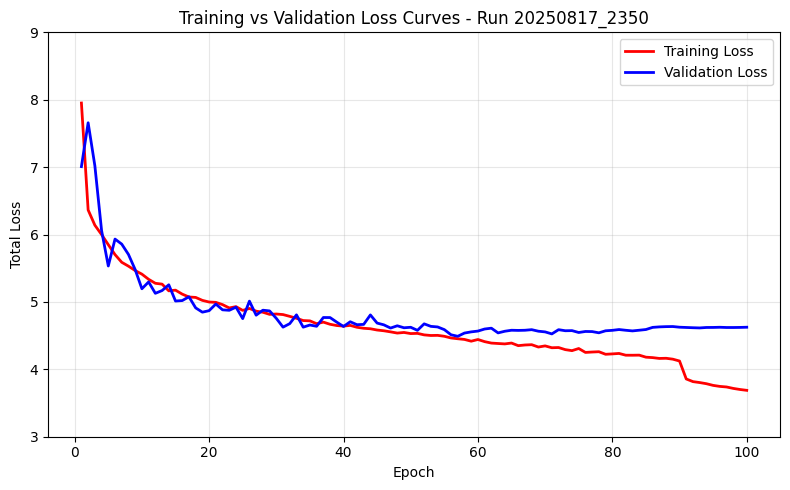

In [35]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

#### 3.3.3 Pre-augmented (hvrt + mosaic) + in situ (hvrt + mosaic)

Note: 
- Uses same data .yaml file as in Section 3.3.1 and above
- Explicitly uses **SGD** as optimizer

In [5]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_msc_bal_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_bal.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [7]:
# Load the model
model = YOLO('yolov8n.pt')

In [9]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug_bal',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # transaltion (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

New https://pypi.org/project/ultralytics/8.3.180 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug_bal.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=1.0, multi_scale=

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_hvrt_msc_bal_alt/labels... 8396 images, 0 backgro


train: New cache created: /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_hvrt_msc_bal_alt/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 21.7±10.5 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels.cache... 463 images, 0 backgrounds, 0 corr


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.2G      2.572      4.481      2.367         16        640: 100%|██████████| 525/525 [02:19<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.114      0.293     0.0676     0.0148

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.42G      2.239      2.121      2.116         17        640: 100%|██████████| 525/525 [03:15<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.203      0.349       0.12     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.42G      2.147      2.091      2.025         14        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.155      0.282      0.123     0.0344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.43G      2.096      2.034      1.995         17        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.292       0.57      0.316      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.44G      2.028      1.927      1.945         16        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.308      0.479      0.306      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.44G      1.986      1.868      1.907         13        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.363       0.54      0.397      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.45G      1.953      1.835      1.869         19        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.355      0.576      0.421      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.46G      1.927      1.792      1.859         17        640: 100%|██████████| 525/525 [03:15<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.329      0.491      0.366      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.46G      1.915      1.797       1.84         17        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.379       0.56      0.399      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.46G      1.872      1.759      1.814         15        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.338      0.641      0.431      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.46G      1.859      1.729      1.805         18        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.432      0.475      0.458      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.46G      1.849      1.726      1.775         14        640: 100%|██████████| 525/525 [03:15<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.303      0.664      0.419      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.46G      1.813      1.699      1.765         19        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.412      0.555      0.495      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.46G      1.795      1.695      1.756         18        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.361      0.624      0.459      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.46G      1.791      1.692      1.746         17        640: 100%|██████████| 525/525 [03:15<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.41      0.578      0.479      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.46G      1.777      1.675       1.73         17        640: 100%|██████████| 525/525 [03:15<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.364      0.644      0.477      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.46G      1.785       1.71       1.73         17        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.449      0.538      0.469        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.46G      1.752      1.708       1.72         19        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.449      0.609      0.525      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.46G       1.74      1.686       1.72         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.436      0.575      0.499      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.46G       1.74      1.688      1.704         16        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.408      0.547      0.461      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.46G      1.716      1.662      1.705         16        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.446      0.528      0.487      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.46G      1.709      1.662      1.699         14        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.44      0.532      0.475      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.46G        1.7      1.664      1.693         19        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.527      0.597      0.541      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.46G      1.698      1.665      1.693         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.497      0.525      0.527      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.46G      1.678      1.632      1.683         15        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.459      0.562      0.518      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.46G      1.661      1.614      1.675         16        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.498      0.576       0.49      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.46G      1.662      1.624      1.664         18        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.489      0.604      0.528      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.46G      1.662      1.615      1.662         14        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.372      0.691        0.5      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.46G      1.641      1.598      1.651         14        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.511      0.617      0.507      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.46G      1.634      1.597      1.656         13        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.501       0.63      0.519      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.46G      1.624      1.587      1.647         14        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.497      0.581      0.523      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.46G       1.63      1.597      1.643         14        640: 100%|██████████| 525/525 [03:16<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<

                   all        463        463       0.47      0.548      0.526      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.46G      1.626      1.601      1.642         16        640: 100%|██████████| 525/525 [03:19<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.447      0.616      0.505      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.46G      1.615      1.581      1.641         14        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.454      0.613      0.517      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.46G      1.594      1.572      1.629         14        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.491      0.577      0.527      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.46G       1.61       1.57      1.634         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.496      0.608      0.553      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.46G      1.591      1.566      1.628         20        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.456       0.66      0.562      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.46G      1.596      1.568      1.627         16        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.466      0.565      0.509      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.46G      1.591      1.566      1.613         22        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.53      0.569      0.545       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.46G      1.583      1.537      1.615         19        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.48      0.631      0.551      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.46G      1.572      1.542      1.617         14        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.534      0.579      0.553      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.46G      1.565      1.547      1.601         15        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.471      0.597       0.54      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.46G      1.567      1.545      1.605         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.511      0.606       0.58       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.46G      1.562      1.542      1.599         18        640: 100%|██████████| 525/525 [03:17<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.498      0.616      0.557      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.46G      1.551      1.538      1.595         18        640: 100%|██████████| 525/525 [03:20<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<

                   all        463        463      0.455      0.641      0.527      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.46G      1.556      1.521      1.593         15        640: 100%|██████████| 525/525 [03:20<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<


                   all        463        463      0.473      0.613      0.542      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.46G      1.542      1.533      1.585         19        640: 100%|██████████| 525/525 [03:20<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<


                   all        463        463       0.49       0.59      0.515      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.46G       1.54      1.525      1.586         14        640: 100%|██████████| 525/525 [03:19<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.474      0.615      0.559      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.46G      1.549      1.525      1.581         16        640: 100%|██████████| 525/525 [03:21<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<

                   all        463        463      0.467      0.625      0.544      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.46G      1.537      1.505      1.574         18        640: 100%|██████████| 525/525 [03:21<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<

                   all        463        463      0.511      0.616      0.576      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.46G      1.522      1.515      1.575         17        640: 100%|██████████| 525/525 [03:22<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<

                   all        463        463      0.528      0.623      0.552      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.46G      1.525      1.511      1.578         16        640: 100%|██████████| 525/525 [03:18<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.512      0.641      0.569      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.46G      1.507      1.501      1.569         19        640: 100%|██████████| 525/525 [03:20<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<

                   all        463        463      0.517      0.619      0.563      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.46G      1.508      1.493       1.56         21        640: 100%|██████████| 525/525 [03:19<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.507       0.61      0.551      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.46G      1.524      1.495      1.567         20        640: 100%|██████████| 525/525 [03:18<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463        0.5      0.645      0.569      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.46G       1.51      1.486      1.561         18        640: 100%|██████████| 525/525 [03:15<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463       0.51      0.637      0.573      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.46G      1.509      1.491      1.563         15        640: 100%|██████████| 525/525 [03:16<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.535      0.621      0.587      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.46G      1.505      1.472      1.561         16        640: 100%|██████████| 525/525 [03:17<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<

                   all        463        463      0.552      0.646       0.58      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.46G      1.496      1.471      1.558         14        640: 100%|██████████| 525/525 [03:15<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.584      0.608      0.603      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.46G      1.494      1.471      1.547         21        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.567      0.625        0.6      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.46G      1.505      1.467      1.563         19        640: 100%|██████████| 525/525 [03:15<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.531      0.646      0.611      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.46G      1.495      1.474      1.554         18        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.577      0.631      0.612      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.46G      1.494      1.463      1.548         20        640: 100%|██████████| 525/525 [03:16<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.58      0.617      0.606      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.46G      1.479      1.449      1.547         16        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463       0.56      0.605      0.581      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.46G      1.479      1.462      1.546         19        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.599      0.611      0.607      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.46G      1.481      1.447      1.547         17        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.576      0.632      0.602      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.46G      1.471       1.45      1.535         19        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.575      0.632      0.616      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.46G      1.471      1.451      1.536         14        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.569      0.638      0.606       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.47G      1.472       1.44      1.535         16        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.59      0.608      0.607      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.47G      1.475      1.434      1.539         17        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.599      0.619      0.613      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.47G      1.467      1.426      1.537         16        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.572      0.632      0.596      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.47G      1.463      1.419      1.532         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.588      0.633      0.604      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.47G      1.451      1.426      1.529         17        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.603      0.631      0.606      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.47G      1.455       1.42      1.527         13        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.602      0.622      0.608      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.47G      1.453      1.419      1.528         16        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.616      0.623      0.594      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.47G      1.446       1.41      1.526         14        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.609      0.619        0.6      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.47G      1.431      1.395       1.52         18        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.601      0.624      0.605      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.47G      1.442      1.403       1.52         18        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.603      0.607      0.599      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.47G      1.427      1.395      1.515         18        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.62      0.618      0.598      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.47G      1.431      1.379      1.513         19        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.617      0.626      0.605      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.47G      1.423      1.376      1.504         15        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.629       0.63      0.623      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.47G      1.428      1.374      1.512         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.62      0.632      0.618      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.47G      1.421      1.375      1.506         18        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.625       0.65      0.635      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.47G      1.408      1.372      1.501         16        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.628      0.627      0.624      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.47G      1.405      1.353       1.49         21        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.627      0.619      0.622      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.47G      1.411      1.359      1.499         18        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.626      0.629       0.62       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.47G      1.404      1.352      1.495         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.629      0.607      0.622       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.47G      1.399      1.345      1.492         18        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.627       0.61      0.625      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     89/100      2.47G      1.399      1.336      1.495         14        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.614       0.63      0.627      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.47G      1.398      1.345      1.486         15        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.619      0.627      0.626      0.291


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.47G      1.343      1.154       1.45         12        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.599      0.632      0.627       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.47G       1.33      1.136      1.444         15        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.593       0.63       0.62      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.47G       1.33      1.125      1.436         12        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.584      0.634      0.617      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.47G      1.312      1.116      1.432         12        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.58      0.649      0.621      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.47G      1.311      1.105      1.429         12        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.58      0.652      0.617      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.47G      1.302      1.095      1.424         12        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.586      0.635      0.616      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.47G      1.303      1.093      1.423         12        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.599       0.64      0.622      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.47G      1.288      1.082      1.418         12        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463        0.6      0.635      0.617      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.47G      1.291      1.078      1.416         12        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.605       0.62      0.618      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.47G      1.283      1.078      1.413         12        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.597      0.617      0.607      0.283



100 epochs completed in 5.582 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.626      0.648      0.635      0.295
             is_vessel        331        331      0.752      0.683      0.788      0.392
            is_fishing        132        132        0.5      0.612      0.481      0.197
Speed: 0.3ms preprocess, 5.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250818_1835


Plot total loss curves:

In [36]:
results_path = RUNS_DIR / 'png_runs'  / 'png_aug_bal' / '20250818_1835'

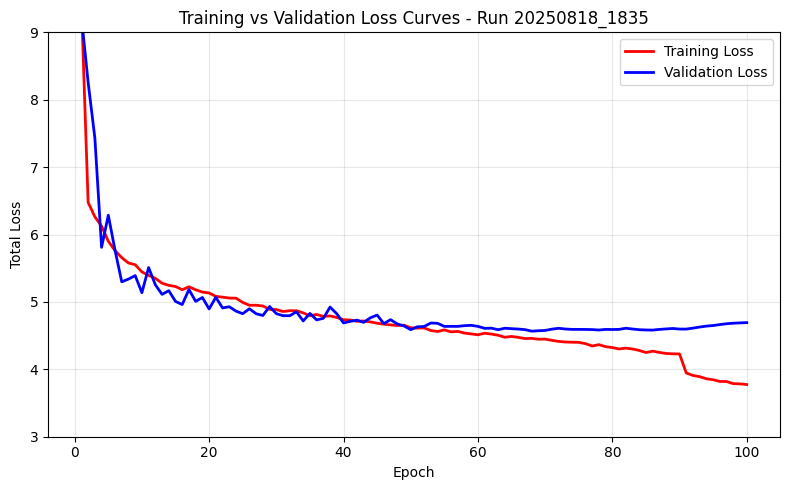

In [37]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

**Parallel run on Kaya** (20250818_2155_681433):

Plot total loss curves:

In [38]:
results_path = RUNS_DIR / 'png_runs'  / 'png_aug_bal' / '20250818_2155_681433'

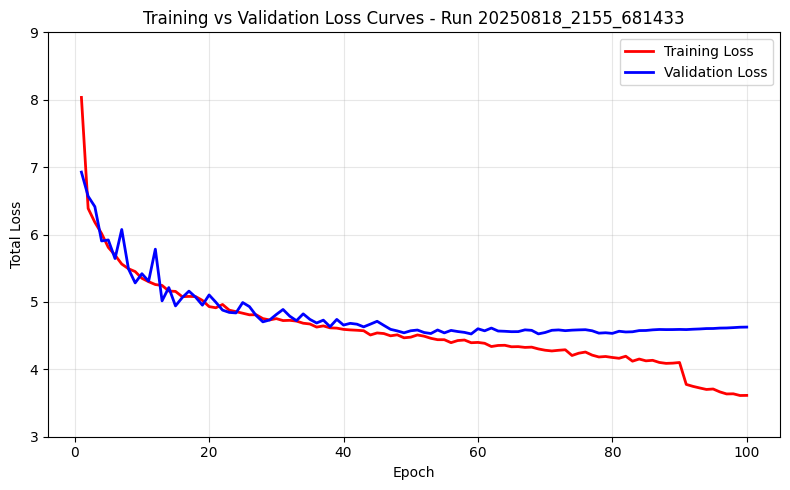

In [39]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

### 3.4 Hyperparameter tuning

#### 3.4.1 L2 regularization using same dataset (Section 3.3.3)

 Use a more aggressive `weight_decay:` 0.0005 -> 0.01

Plot total loss curves:

In [40]:
results_path = RUNS_DIR / 'png_runs'  / 'png_aug_bal' / '20250819_1623_681711'

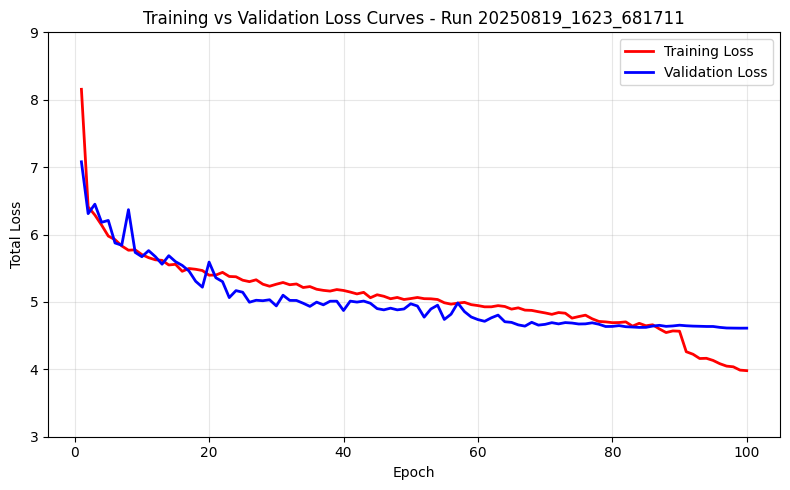

In [41]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

Overfitting has reduced but training loss is higher and validation loss is unchanged.

Try a less aggressive L2 weight_decay `weight_decay=0.001`

### 3.5 Crop size **640 x 640** pixels dateset 

Larger image crops size (c.f. prior 96 x 96 pixels) with either single-objection annotation ('original crops') or multi-object annotations ('spatial crops').

#### 3.5.1 Balanced, pre-augmented (hvrt + mosaic) + in situ (hvrt + mosaic), `spatial crops`.

Plot total loss curves:

In [42]:
results_path = RUNS_DIR / 'png_runs'  / 'png_640s_aug' / '20250821_1131_683221'

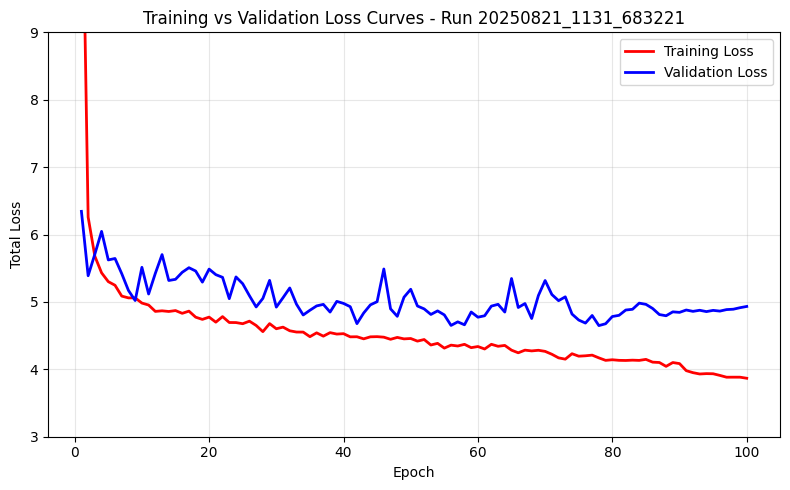

In [43]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

#### 3.5.2 Balanced, pre-augmented (hvrt + ~~mosaic~~) + in situ (hvrt + mosaic), `spatial crops`.

**Pre-augmented mosaics removed**

Plot total loss curves:

In [44]:
results_path = RUNS_DIR / 'png_runs'  / 'png_640s_aug' / '20250823_0908_684970'

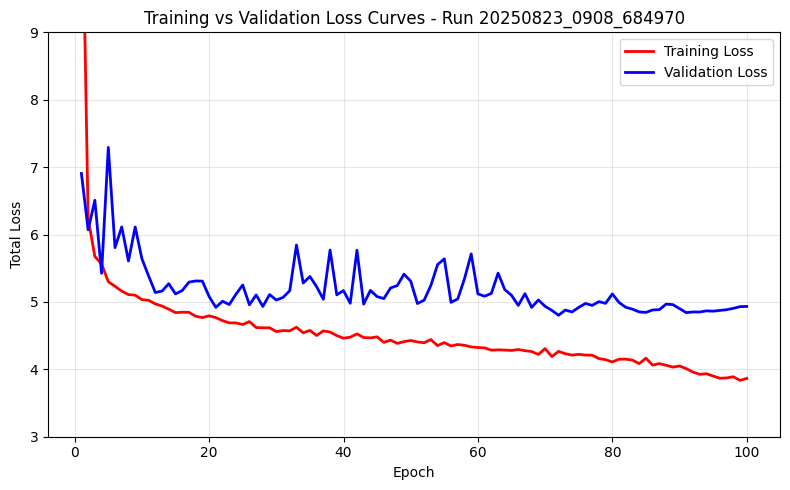

In [45]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

Comparing the plots in Sections 3.5.1 & 3.5.2 - 640x640 pixel spatial crops dataset with and without pre-augmented mosaics, respectively, the addition of pre-augmented mosaics does result in a tangible *improvement* in performance (metrics confrim this). This makes sense because the mosaics are more akin to the multi-object detections characteristic of spatial crops.

#### 3.5.3 Balanced, pre-augmented (hvrt + mosaic) + in situ (hvrt + mosaic), `original crops`.

Plot total loss curves:

In [46]:
results_path = RUNS_DIR / 'png_runs'  / 'png_640_aug' / '20250821_1522_683829'

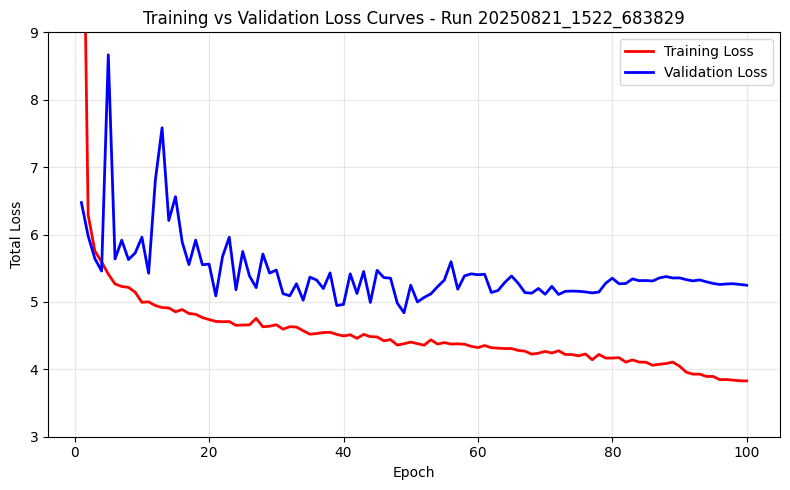

In [47]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

#### 3.5.4 Balanced, pre-augmented (hvrt + ~~mosaic~~) + in situ (hvrt + mosaic), `original crops`.

**Pre-augmented mosaics removed**

Plot total loss curves:

In [48]:
results_path = RUNS_DIR / 'png_runs'  / 'png_640_aug' / '20250821_1950_684440'

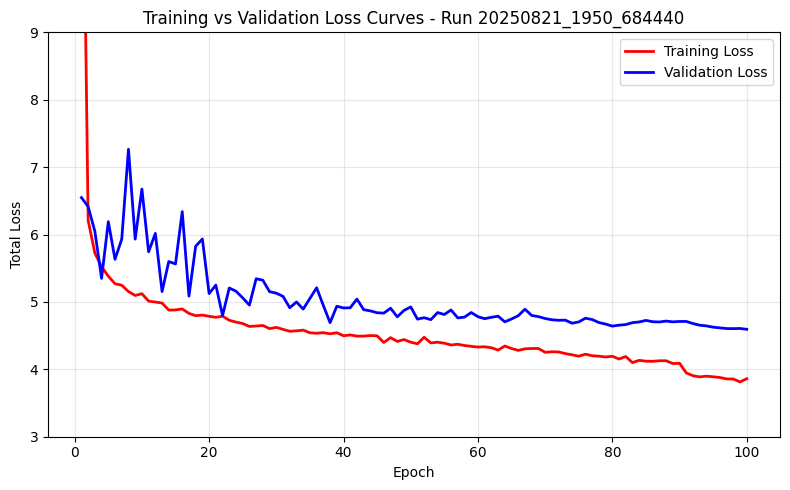

In [49]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

The reverse seems to be true of non-spatial (original) crops. This also makes sense because the mosaics are represented in the dataset as only small minority and the model doesn't learn to recognise multi-object annotations per crop as well. In fact, with these large image crops, the chance of multiple objects in an individual crop is much higher and if they are not annotated, the model may get confused. 

Note that there may be also case for extending the training in the latter as the validation curve has not quite levelled off.

*Lets see if removing the in situ mosaics improves the original performance even more...*

#### 3.5.4 Balanced, pre-augmented (hvrt + ~~mosaic~~) + in situ (hvrt + ~~mosaic~~), `original crops`.

**All mosaics removed (pre-augmented + in situ)**

Plot total loss curves:

In [50]:
results_path = RUNS_DIR / 'png_runs'  / 'png_640_aug' / '20250822_1145_684838'

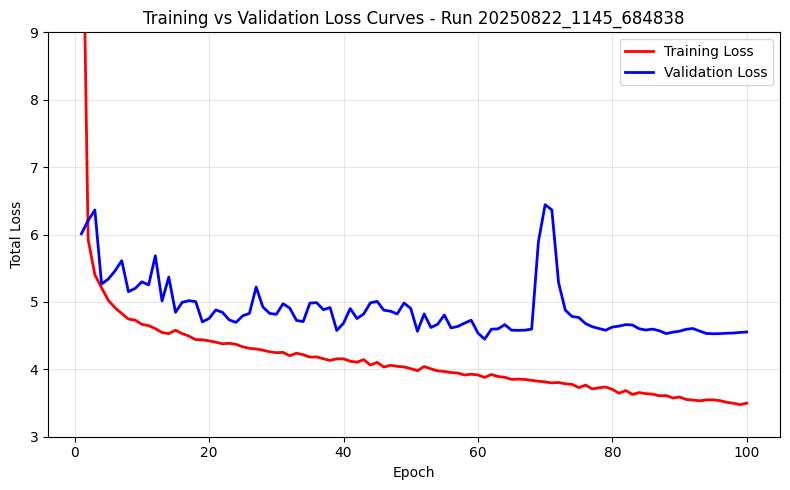

In [51]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

The validation loss appears to degrade with some instability in the latter epochs without the in situ mosaic augmentation however the best model validation metrics indicate it outperforms the models using datasets with som form of mosaic augmentation. This aligns with the suppostion made earlier.

### 3.6 Crop size **96 x 96** pixel `spatial crops` dataset 

96 x 96 pixel image crops size with multi-object annotations ('spatial crops').

#### 3.6.1 Balanced, pre-augmented (hvrt + mosaic) + in situ (hvrt + mosaic), `spatial crops`.

In [4]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_png_96s_aug',
    'val':    'val_png_96s', 
    'test':   'test_png_96s',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_96s_aug_bal.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [5]:
# Load the model
model = YOLO('yolov8n.pt')

In [6]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_96s_aug',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # transaltion (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

New https://pypi.org/project/ultralytics/8.3.184 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_96s_aug_bal.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=1.0, multi_sc

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_png_96s_aug/labels.cache... 8318 images, 0 backgr


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 16.9±10.7 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_png_96s/labels.cache... 454 images, 0 backgrounds, 0 


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.93G      2.301      3.366      2.218         16        640: 100%|██████████| 520/520 [01:40<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        454        470      0.252      0.403      0.253     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.24G      2.089      2.314      1.964         21        640: 100%|██████████| 520/520 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.128      0.332     0.0997     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.25G      2.078      2.199      1.912         19        640: 100%|██████████| 520/520 [01:45<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.257      0.398      0.229     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.26G      2.042      2.119      1.904         22        640: 100%|██████████| 520/520 [02:59<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.268      0.453      0.306      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.26G      1.995      2.018      1.856         22        640: 100%|██████████| 520/520 [01:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.406      0.604      0.406       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.26G      1.952      1.964      1.817         22        640: 100%|██████████| 520/520 [02:52<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470     0.0308     0.0304     0.0105    0.00338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.26G      1.928      1.915      1.804         21        640: 100%|██████████| 520/520 [02:05<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470       0.39      0.483      0.409      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.26G      1.906       1.88      1.786         25        640: 100%|██████████| 520/520 [02:25<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.317      0.495      0.415      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.26G      1.874      1.856      1.753         20        640: 100%|██████████| 520/520 [02:19<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.426       0.54       0.49      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.26G      1.863       1.82      1.746         17        640: 100%|██████████| 520/520 [02:16<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.402      0.551      0.483      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.26G      1.834      1.808      1.736         20        640: 100%|██████████| 520/520 [02:25<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.396      0.579      0.439      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.26G      1.818      1.789      1.717         21        640: 100%|██████████| 520/520 [01:49<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.448      0.518      0.436      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.26G      1.803      1.768      1.697         16        640: 100%|██████████| 520/520 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.372      0.603       0.48      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.26G      1.793       1.77      1.689         18        640: 100%|██████████| 520/520 [01:50<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.398       0.53      0.466      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.26G      1.782       1.76      1.663         18        640: 100%|██████████| 520/520 [02:25<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.402      0.606      0.478      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.26G      1.761      1.719      1.663         24        640: 100%|██████████| 520/520 [02:20<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.419      0.587      0.481      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.26G      1.756      1.734      1.655         21        640: 100%|██████████| 520/520 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.474      0.495      0.477      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.26G      1.751      1.713      1.665         18        640: 100%|██████████| 520/520 [02:46<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.411      0.527      0.452      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.26G      1.735      1.702      1.646         21        640: 100%|██████████| 520/520 [01:36<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.464      0.555      0.489       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.26G      1.727      1.712      1.637         22        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.398      0.532      0.469        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.26G      1.718      1.692      1.625         20        640: 100%|██████████| 520/520 [02:08<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.449      0.514      0.449      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.26G      1.706      1.683      1.625         20        640: 100%|██████████| 520/520 [02:20<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.504      0.512      0.489       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.26G      1.694      1.665       1.61         17        640: 100%|██████████| 520/520 [02:19<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.486      0.542      0.484      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.26G      1.685      1.653      1.602         18        640: 100%|██████████| 520/520 [01:51<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470       0.53      0.532      0.471      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.26G       1.68      1.658      1.605         15        640: 100%|██████████| 520/520 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.433      0.584      0.481      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.26G      1.676      1.645      1.596         22        640: 100%|██████████| 520/520 [01:51<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.463      0.551      0.504      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.26G      1.659      1.642      1.588         20        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.478      0.544      0.472      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.26G      1.657      1.629      1.589         24        640: 100%|██████████| 520/520 [02:19<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.435      0.564      0.495      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.26G      1.657      1.627       1.59         20        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.489      0.541      0.477      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.26G      1.636      1.633      1.575         17        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.515      0.572      0.507      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.26G      1.636      1.624      1.578         20        640: 100%|██████████| 520/520 [01:53<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.502      0.577       0.53       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.26G      1.639       1.62      1.578         22        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.493      0.572       0.52       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.26G       1.62      1.602      1.571         19        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.503      0.568      0.518      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.26G      1.621       1.61      1.565         19        640: 100%|██████████| 520/520 [01:56<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470        0.5      0.556      0.492      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.26G      1.606        1.6      1.555         22        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.518      0.592      0.556      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.26G      1.613      1.587      1.558         22        640: 100%|██████████| 520/520 [01:58<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470       0.49      0.602      0.547      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.26G      1.594      1.569      1.548         17        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.558      0.592      0.562      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.26G      1.593      1.586      1.555         21        640: 100%|██████████| 520/520 [02:04<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.524      0.537      0.486      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.26G      1.591      1.572      1.546         20        640: 100%|██████████| 520/520 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.476      0.597      0.523      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.26G      1.587      1.579      1.538         25        640: 100%|██████████| 520/520 [02:03<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.543      0.599      0.534      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.26G      1.585      1.574      1.542         23        640: 100%|██████████| 520/520 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.507      0.583      0.551      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.26G      1.574      1.564      1.537         19        640: 100%|██████████| 520/520 [02:30<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.552      0.582      0.541      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.26G       1.57      1.563      1.534         19        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.526      0.572      0.546      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.26G      1.567      1.564      1.533         25        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.487      0.613      0.544      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.26G      1.566      1.557      1.534         15        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.548      0.574      0.561      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.26G      1.553      1.543      1.526         18        640: 100%|██████████| 520/520 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.529      0.579      0.558      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.26G      1.561      1.545      1.527         19        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.514      0.569      0.536       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.26G      1.555      1.538      1.526         18        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.499      0.583      0.543      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.26G      1.547      1.529      1.522         25        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.546      0.568      0.542      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.26G      1.536      1.539      1.515         21        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.512      0.611      0.547      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.26G      1.546      1.522      1.519         19        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.565      0.562      0.548      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.26G      1.547      1.511      1.512         19        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.511       0.57      0.553      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.26G      1.529      1.508      1.516         24        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.514       0.61      0.553      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.26G      1.531      1.509      1.508         18        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.51       0.58      0.541      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.26G      1.522      1.489      1.508         17        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.508      0.563      0.533      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.26G       1.51        1.5      1.496         20        640: 100%|██████████| 520/520 [03:20<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.53      0.546       0.54      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.26G      1.519      1.498      1.497         18        640: 100%|██████████| 520/520 [03:20<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.517      0.566      0.518      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.26G      1.493      1.477      1.481         16        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.565      0.585       0.54      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.26G      1.501       1.49      1.489         20        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.553       0.57      0.538      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.26G      1.495      1.474      1.493         21        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.547      0.612      0.552      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.26G      1.497      1.473      1.487         20        640: 100%|██████████| 520/520 [03:07<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.568      0.568      0.559      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.26G      1.492      1.473      1.486         18        640: 100%|██████████| 520/520 [03:07<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.527      0.613      0.546      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.26G      1.479      1.456      1.483         20        640: 100%|██████████| 520/520 [02:16<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.538       0.62      0.562      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.26G      1.477      1.453      1.473         16        640: 100%|██████████| 520/520 [02:45<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.51      0.626      0.548      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.26G      1.481      1.459      1.475         19        640: 100%|██████████| 520/520 [03:07<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.491      0.591      0.525      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.26G       1.47      1.452      1.466         21        640: 100%|██████████| 520/520 [02:05<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.566       0.57      0.548      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.26G      1.473      1.431      1.467         23        640: 100%|██████████| 520/520 [03:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.519      0.597      0.527      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.26G      1.463      1.434      1.464         19        640: 100%|██████████| 520/520 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.527      0.592      0.546      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.26G      1.456      1.421       1.46         21        640: 100%|██████████| 520/520 [03:07<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470       0.54       0.61      0.558      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.26G      1.459      1.427       1.46         17        640: 100%|██████████| 520/520 [01:54<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.541      0.582      0.548      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.26G      1.443      1.422      1.451         21        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.537      0.622      0.537      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.26G      1.436       1.42      1.445         23        640: 100%|██████████| 520/520 [02:14<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.554      0.618      0.547      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.26G      1.446      1.416      1.453         18        640: 100%|██████████| 520/520 [02:11<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.556      0.605      0.548      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.26G      1.443      1.418      1.449         20        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.548      0.593       0.54      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.26G      1.438      1.396      1.449         22        640: 100%|██████████| 520/520 [01:51<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.525      0.593      0.537      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.26G      1.432      1.395      1.444         18        640: 100%|██████████| 520/520 [02:31<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.555      0.569      0.523       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.26G      1.421      1.387      1.439         20        640: 100%|██████████| 520/520 [02:31<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.545      0.576      0.523       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.26G      1.422      1.386       1.44         17        640: 100%|██████████| 520/520 [01:48<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.539      0.603      0.523      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.26G      1.422      1.379      1.436         20        640: 100%|██████████| 520/520 [02:17<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.562      0.602      0.527      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.26G       1.42      1.367      1.435         22        640: 100%|██████████| 520/520 [02:40<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.551      0.593      0.529      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.26G      1.413      1.358      1.428         18        640: 100%|██████████| 520/520 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.561      0.584      0.531      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.26G      1.406      1.349      1.433         19        640: 100%|██████████| 520/520 [02:21<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.554      0.574      0.536      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.26G      1.403      1.373      1.422         22        640: 100%|██████████| 520/520 [02:28<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.562      0.584      0.537      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.26G      1.393      1.339       1.42         19        640: 100%|██████████| 520/520 [02:01<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.56      0.578      0.535      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.26G      1.398      1.342      1.421         22        640: 100%|██████████| 520/520 [01:53<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.558      0.585      0.532       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.26G      1.402       1.33      1.425         22        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.544      0.585      0.527      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.26G      1.384      1.327      1.418         25        640: 100%|██████████| 520/520 [02:02<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.559      0.582      0.536      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.26G      1.381      1.331       1.41         21        640: 100%|██████████| 520/520 [01:49<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.556      0.608      0.549       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.26G      1.372      1.319      1.409         22        640: 100%|██████████| 520/520 [02:33<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.553      0.609      0.551      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.26G      1.374      1.314       1.41         23        640: 100%|██████████| 520/520 [02:09<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.553      0.599       0.55      0.263


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.26G      1.312      1.121       1.35         19        640: 100%|██████████| 520/520 [01:52<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.567      0.594      0.555      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.26G      1.297      1.101      1.341         14        640: 100%|██████████| 520/520 [02:41<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.554      0.597      0.554      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.26G      1.293      1.087      1.339         14        640: 100%|██████████| 520/520 [01:52<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.562        0.6      0.555      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.26G      1.284      1.077      1.334         15        640: 100%|██████████| 520/520 [01:59<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.555      0.605      0.557      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.26G      1.281      1.072      1.331         14        640: 100%|██████████| 520/520 [02:40<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.564      0.615      0.563      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.26G      1.271      1.062      1.324         15        640: 100%|██████████| 520/520 [01:30<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.555      0.616      0.561      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.26G      1.267      1.048      1.321         17        640: 100%|██████████| 520/520 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.554      0.622       0.56      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.26G       1.26      1.048      1.324         17        640: 100%|██████████| 520/520 [02:17<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.56      0.614      0.561      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.26G      1.256       1.04      1.312         14        640: 100%|██████████| 520/520 [01:43<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.563      0.612       0.56      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.26G      1.252      1.034      1.314         16        640: 100%|██████████| 520/520 [02:09<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.563      0.592      0.559       0.26



100 epochs completed in 4.332 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        454        470      0.561      0.613      0.562      0.266
             is_vessel        325        338      0.746      0.633      0.722      0.361
            is_fishing        131        132      0.376      0.594      0.403      0.171
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959


Plot total loss curves:

In [52]:
results_path = RUNS_DIR / 'png_runs'  / 'png_96s_aug' / '20250824_1959'

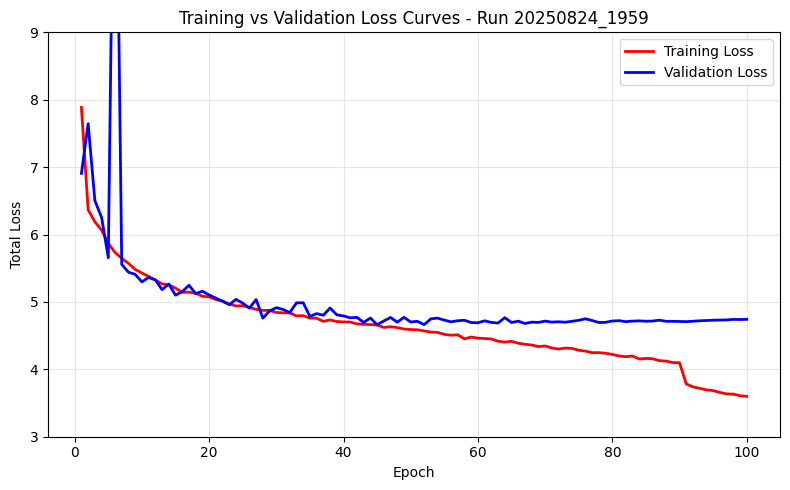

In [53]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

### 3.7 Using a larger model: **YOLOv8m.pt**

Same dataset and model configuration as in Section 3.3.3 i.e. balanced, pre-augmented (hvrt + mosaic) + in situ (hvrt + mosaic), `original` 96 x 96 pixel crops (Optimizer ='auto' chose SGD).

In [4]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_msc_bal_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_96s_aug_bal.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [5]:
# Load the model
model = YOLO('yolov8m.pt')

In [6]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug_bal',
    name=timestamp,
    
    # Optimization
    optimizer='auto',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # transaltion (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

New https://pypi.org/project/ultralytics/8.3.184 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_96s_aug_bal.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=1.0, multi_sc

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_png_96s_aug/labels.cache... 8318 images, 0 backgr


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 16.9±10.7 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_png_96s/labels.cache... 454 images, 0 backgrounds, 0 


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.93G      2.301      3.366      2.218         16        640: 100%|██████████| 520/520 [01:40<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        454        470      0.252      0.403      0.253     0.0766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.24G      2.089      2.314      1.964         21        640: 100%|██████████| 520/520 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.128      0.332     0.0997     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.25G      2.078      2.199      1.912         19        640: 100%|██████████| 520/520 [01:45<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.257      0.398      0.229     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.26G      2.042      2.119      1.904         22        640: 100%|██████████| 520/520 [02:59<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.268      0.453      0.306      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.26G      1.995      2.018      1.856         22        640: 100%|██████████| 520/520 [01:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.406      0.604      0.406       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.26G      1.952      1.964      1.817         22        640: 100%|██████████| 520/520 [02:52<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470     0.0308     0.0304     0.0105    0.00338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.26G      1.928      1.915      1.804         21        640: 100%|██████████| 520/520 [02:05<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470       0.39      0.483      0.409      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.26G      1.906       1.88      1.786         25        640: 100%|██████████| 520/520 [02:25<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.317      0.495      0.415      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.26G      1.874      1.856      1.753         20        640: 100%|██████████| 520/520 [02:19<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.426       0.54       0.49      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.26G      1.863       1.82      1.746         17        640: 100%|██████████| 520/520 [02:16<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.402      0.551      0.483      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.26G      1.834      1.808      1.736         20        640: 100%|██████████| 520/520 [02:25<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.396      0.579      0.439      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.26G      1.818      1.789      1.717         21        640: 100%|██████████| 520/520 [01:49<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.448      0.518      0.436      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.26G      1.803      1.768      1.697         16        640: 100%|██████████| 520/520 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.372      0.603       0.48      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.26G      1.793       1.77      1.689         18        640: 100%|██████████| 520/520 [01:50<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.398       0.53      0.466      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.26G      1.782       1.76      1.663         18        640: 100%|██████████| 520/520 [02:25<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.402      0.606      0.478      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.26G      1.761      1.719      1.663         24        640: 100%|██████████| 520/520 [02:20<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.419      0.587      0.481      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.26G      1.756      1.734      1.655         21        640: 100%|██████████| 520/520 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.474      0.495      0.477      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.26G      1.751      1.713      1.665         18        640: 100%|██████████| 520/520 [02:46<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.411      0.527      0.452      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.26G      1.735      1.702      1.646         21        640: 100%|██████████| 520/520 [01:36<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.464      0.555      0.489       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.26G      1.727      1.712      1.637         22        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.398      0.532      0.469        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.26G      1.718      1.692      1.625         20        640: 100%|██████████| 520/520 [02:08<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.449      0.514      0.449      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.26G      1.706      1.683      1.625         20        640: 100%|██████████| 520/520 [02:20<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.504      0.512      0.489       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.26G      1.694      1.665       1.61         17        640: 100%|██████████| 520/520 [02:19<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.486      0.542      0.484      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.26G      1.685      1.653      1.602         18        640: 100%|██████████| 520/520 [01:51<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470       0.53      0.532      0.471      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.26G       1.68      1.658      1.605         15        640: 100%|██████████| 520/520 [02:54<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.433      0.584      0.481      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.26G      1.676      1.645      1.596         22        640: 100%|██████████| 520/520 [01:51<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.463      0.551      0.504      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.26G      1.659      1.642      1.588         20        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.478      0.544      0.472      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.26G      1.657      1.629      1.589         24        640: 100%|██████████| 520/520 [02:19<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.435      0.564      0.495      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.26G      1.657      1.627       1.59         20        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.489      0.541      0.477      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.26G      1.636      1.633      1.575         17        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.515      0.572      0.507      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.26G      1.636      1.624      1.578         20        640: 100%|██████████| 520/520 [01:53<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.502      0.577       0.53       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.26G      1.639       1.62      1.578         22        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.493      0.572       0.52       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.26G       1.62      1.602      1.571         19        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.503      0.568      0.518      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.26G      1.621       1.61      1.565         19        640: 100%|██████████| 520/520 [01:56<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470        0.5      0.556      0.492      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.26G      1.606        1.6      1.555         22        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.518      0.592      0.556      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.26G      1.613      1.587      1.558         22        640: 100%|██████████| 520/520 [01:58<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470       0.49      0.602      0.547      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.26G      1.594      1.569      1.548         17        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.558      0.592      0.562      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.26G      1.593      1.586      1.555         21        640: 100%|██████████| 520/520 [02:04<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.524      0.537      0.486      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.26G      1.591      1.572      1.546         20        640: 100%|██████████| 520/520 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.476      0.597      0.523      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.26G      1.587      1.579      1.538         25        640: 100%|██████████| 520/520 [02:03<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.543      0.599      0.534      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.26G      1.585      1.574      1.542         23        640: 100%|██████████| 520/520 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.507      0.583      0.551      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.26G      1.574      1.564      1.537         19        640: 100%|██████████| 520/520 [02:30<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.552      0.582      0.541      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.26G       1.57      1.563      1.534         19        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.526      0.572      0.546      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.26G      1.567      1.564      1.533         25        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.487      0.613      0.544      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.26G      1.566      1.557      1.534         15        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.548      0.574      0.561      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.26G      1.553      1.543      1.526         18        640: 100%|██████████| 520/520 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.529      0.579      0.558      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.26G      1.561      1.545      1.527         19        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.514      0.569      0.536       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.26G      1.555      1.538      1.526         18        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.499      0.583      0.543      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.26G      1.547      1.529      1.522         25        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.546      0.568      0.542      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.26G      1.536      1.539      1.515         21        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.512      0.611      0.547      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.26G      1.546      1.522      1.519         19        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.565      0.562      0.548      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.26G      1.547      1.511      1.512         19        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.511       0.57      0.553      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.26G      1.529      1.508      1.516         24        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.514       0.61      0.553      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.26G      1.531      1.509      1.508         18        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.51       0.58      0.541      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.26G      1.522      1.489      1.508         17        640: 100%|██████████| 520/520 [03:09<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.508      0.563      0.533      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.26G       1.51        1.5      1.496         20        640: 100%|██████████| 520/520 [03:20<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.53      0.546       0.54      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.26G      1.519      1.498      1.497         18        640: 100%|██████████| 520/520 [03:20<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.517      0.566      0.518      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.26G      1.493      1.477      1.481         16        640: 100%|██████████| 520/520 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.565      0.585       0.54      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.26G      1.501       1.49      1.489         20        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.553       0.57      0.538      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.26G      1.495      1.474      1.493         21        640: 100%|██████████| 520/520 [03:08<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.547      0.612      0.552      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.26G      1.497      1.473      1.487         20        640: 100%|██████████| 520/520 [03:07<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.568      0.568      0.559      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.26G      1.492      1.473      1.486         18        640: 100%|██████████| 520/520 [03:07<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.527      0.613      0.546      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.26G      1.479      1.456      1.483         20        640: 100%|██████████| 520/520 [02:16<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.538       0.62      0.562      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.26G      1.477      1.453      1.473         16        640: 100%|██████████| 520/520 [02:45<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.51      0.626      0.548      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.26G      1.481      1.459      1.475         19        640: 100%|██████████| 520/520 [03:07<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.491      0.591      0.525      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.26G       1.47      1.452      1.466         21        640: 100%|██████████| 520/520 [02:05<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.566       0.57      0.548      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.26G      1.473      1.431      1.467         23        640: 100%|██████████| 520/520 [03:03<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.519      0.597      0.527      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.26G      1.463      1.434      1.464         19        640: 100%|██████████| 520/520 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.527      0.592      0.546      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.26G      1.456      1.421       1.46         21        640: 100%|██████████| 520/520 [03:07<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470       0.54       0.61      0.558      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.26G      1.459      1.427       1.46         17        640: 100%|██████████| 520/520 [01:54<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.541      0.582      0.548      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.26G      1.443      1.422      1.451         21        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.537      0.622      0.537      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.26G      1.436       1.42      1.445         23        640: 100%|██████████| 520/520 [02:14<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.554      0.618      0.547      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.26G      1.446      1.416      1.453         18        640: 100%|██████████| 520/520 [02:11<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.556      0.605      0.548      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.26G      1.443      1.418      1.449         20        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.548      0.593       0.54      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.26G      1.438      1.396      1.449         22        640: 100%|██████████| 520/520 [01:51<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.525      0.593      0.537      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.26G      1.432      1.395      1.444         18        640: 100%|██████████| 520/520 [02:31<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.555      0.569      0.523       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.26G      1.421      1.387      1.439         20        640: 100%|██████████| 520/520 [02:31<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.545      0.576      0.523       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.26G      1.422      1.386       1.44         17        640: 100%|██████████| 520/520 [01:48<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.539      0.603      0.523      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.26G      1.422      1.379      1.436         20        640: 100%|██████████| 520/520 [02:17<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.562      0.602      0.527      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.26G       1.42      1.367      1.435         22        640: 100%|██████████| 520/520 [02:40<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.551      0.593      0.529      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.26G      1.413      1.358      1.428         18        640: 100%|██████████| 520/520 [01:46<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.561      0.584      0.531      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.26G      1.406      1.349      1.433         19        640: 100%|██████████| 520/520 [02:21<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.554      0.574      0.536      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.26G      1.403      1.373      1.422         22        640: 100%|██████████| 520/520 [02:28<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.562      0.584      0.537      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.26G      1.393      1.339       1.42         19        640: 100%|██████████| 520/520 [02:01<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.56      0.578      0.535      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.26G      1.398      1.342      1.421         22        640: 100%|██████████| 520/520 [01:53<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.558      0.585      0.532       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.26G      1.402       1.33      1.425         22        640: 100%|██████████| 520/520 [02:39<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.544      0.585      0.527      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.26G      1.384      1.327      1.418         25        640: 100%|██████████| 520/520 [02:02<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.559      0.582      0.536      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.26G      1.381      1.331       1.41         21        640: 100%|██████████| 520/520 [01:49<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.556      0.608      0.549       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.26G      1.372      1.319      1.409         22        640: 100%|██████████| 520/520 [02:33<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.553      0.609      0.551      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.26G      1.374      1.314       1.41         23        640: 100%|██████████| 520/520 [02:09<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.553      0.599       0.55      0.263


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.26G      1.312      1.121       1.35         19        640: 100%|██████████| 520/520 [01:52<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.567      0.594      0.555      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.26G      1.297      1.101      1.341         14        640: 100%|██████████| 520/520 [02:41<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.554      0.597      0.554      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.26G      1.293      1.087      1.339         14        640: 100%|██████████| 520/520 [01:52<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        454        470      0.562        0.6      0.555      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.26G      1.284      1.077      1.334         15        640: 100%|██████████| 520/520 [01:59<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.555      0.605      0.557      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.26G      1.281      1.072      1.331         14        640: 100%|██████████| 520/520 [02:40<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.564      0.615      0.563      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.26G      1.271      1.062      1.324         15        640: 100%|██████████| 520/520 [01:30<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.555      0.616      0.561      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.26G      1.267      1.048      1.321         17        640: 100%|██████████| 520/520 [02:36<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        454        470      0.554      0.622       0.56      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.26G       1.26      1.048      1.324         17        640: 100%|██████████| 520/520 [02:17<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470       0.56      0.614      0.561      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.26G      1.256       1.04      1.312         14        640: 100%|██████████| 520/520 [01:43<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        454        470      0.563      0.612       0.56      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.26G      1.252      1.034      1.314         16        640: 100%|██████████| 520/520 [02:09<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        454        470      0.563      0.592      0.559       0.26



100 epochs completed in 4.332 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<


                   all        454        470      0.561      0.613      0.562      0.266
             is_vessel        325        338      0.746      0.633      0.722      0.361
            is_fishing        131        132      0.376      0.594      0.403      0.171
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_96s_aug/20250824_1959


Plot total loss curves:

In [54]:
results_path = RUNS_DIR / 'png_runs'  / 'png_aug_bal' / '20250824_1730_685055'

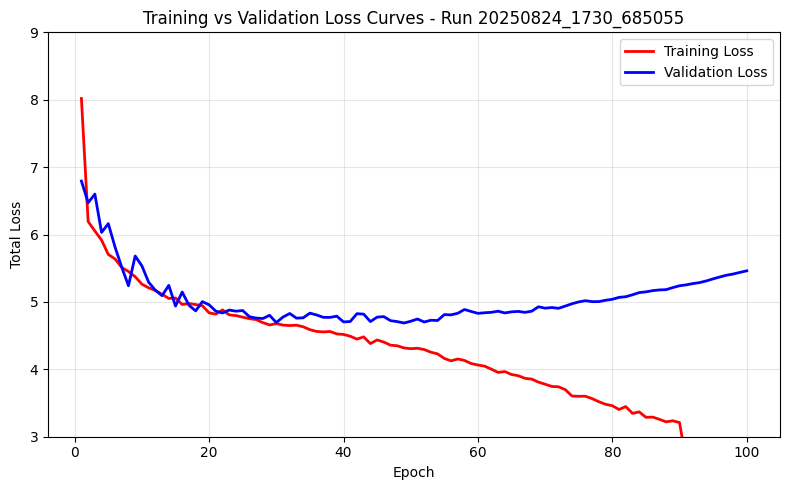

In [55]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

### 3.8 Reproduce 'best' model, same dataset, same parameters

Set close-mosaic=0 to remove tail on loss curves

Plot total loss curves:

In [56]:
results_path = RUNS_DIR / 'png_runs'  / 'png_aug_bal' / '20250826_2203_685644'

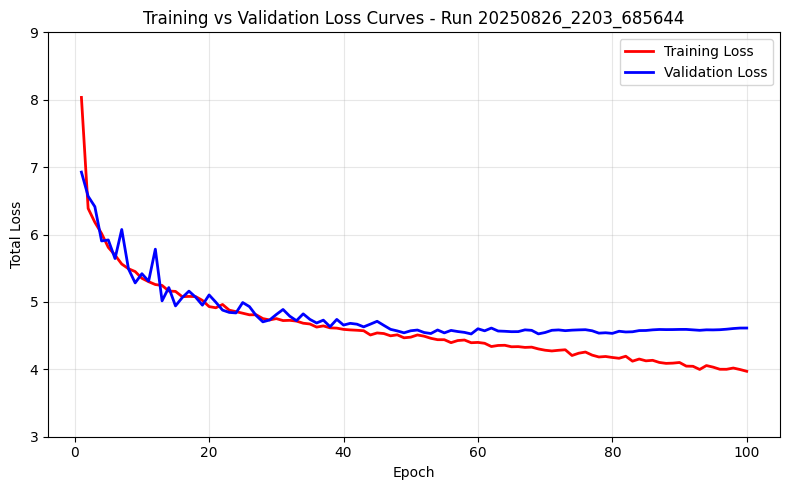

In [57]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

Second attempt on Phenom-II

In [13]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_msc_bal_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_bal.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [14]:
# Load the model
model = YOLO('yolov8n.pt')

In [16]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    close_mosaic=0,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug_bal',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # translation (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=None, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/peterm/UWA/CITS5014/SARFish/modelling/configs/png_aug_bal.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.9, mosaic=1.0, multi_scale=F

train: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/train_hvrt_msc_bal_alt/labels.cache... 8396 images, 0 b

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 25.4±5.7 MB/s, size: 20.6 KB)


val: Scanning /home/peterm/UWA/CITS5014/SARFish/modelling/data/val_alt/labels.cache... 463 images, 0 backgrounds, 0 corr


Plotting labels to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250827_1026/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250827_1026
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.65G      2.313      3.397      2.213         16        640: 100%|██████████| 525/525 [01:41<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.274      0.401      0.218     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.96G      2.099      2.288      1.919         17        640: 100%|██████████| 525/525 [02:47<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.293      0.388      0.248     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.97G      2.078      2.181      1.928         14        640: 100%|██████████| 525/525 [01:51<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.219      0.352      0.207     0.0657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.98G      2.058      2.109      1.891         17        640: 100%|██████████| 525/525 [02:55<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.289      0.399      0.252     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.99G      1.976      1.998      1.831         16        640: 100%|██████████| 525/525 [02:04<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.304      0.497      0.353      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         4G      1.949      1.937      1.817         13        640: 100%|██████████| 525/525 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.342      0.546      0.408      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.66G      1.926      1.887      1.794         19        640: 100%|██████████| 525/525 [02:00<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.278      0.561       0.38      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.66G      1.892      1.848      1.766         17        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.347      0.168      0.176     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.66G      1.883      1.855      1.759         17        640: 100%|██████████| 525/525 [02:06<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.331       0.61      0.446      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.66G      1.854      1.807      1.728         15        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.35      0.633       0.49      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.66G      1.829      1.786      1.728         18        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.372      0.561      0.459      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.68G      1.826      1.774      1.695         14        640: 100%|██████████| 525/525 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.308       0.65      0.467      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.68G      1.797       1.75      1.689         19        640: 100%|██████████| 525/525 [02:11<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.365      0.599      0.474      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.68G      1.773      1.731      1.682         18        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.391      0.602      0.512      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.68G      1.773      1.728      1.681         17        640: 100%|██████████| 525/525 [01:50<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.366      0.634      0.501      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.68G      1.764      1.704      1.658         17        640: 100%|██████████| 525/525 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463        0.4      0.522      0.442      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.68G      1.757      1.719      1.652         17        640: 100%|██████████| 525/525 [01:55<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.411      0.588      0.485       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.68G      1.726      1.693      1.637         19        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.415        0.6      0.508      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.69G      1.719      1.676      1.639         17        640: 100%|██████████| 525/525 [01:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.432      0.577      0.532       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.69G      1.719      1.681      1.634         16        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.444      0.581      0.493      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.69G      1.703      1.664       1.63         16        640: 100%|██████████| 525/525 [02:07<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.463       0.58      0.545      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.69G      1.689      1.649      1.621         14        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.427      0.559      0.489      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.69G      1.687      1.647      1.617         19        640: 100%|██████████| 525/525 [02:54<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.439      0.609      0.526      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.69G      1.677      1.653      1.607         17        640: 100%|██████████| 525/525 [02:16<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.444      0.573      0.523      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.69G       1.66      1.625      1.596         15        640: 100%|██████████| 525/525 [02:27<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.41      0.587      0.504      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.69G      1.648      1.604      1.591         16        640: 100%|██████████| 525/525 [02:29<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.452      0.569      0.484      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.69G      1.647      1.622      1.579         18        640: 100%|██████████| 525/525 [01:57<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.478      0.627       0.55      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.69G      1.643      1.602       1.58         14        640: 100%|██████████| 525/525 [02:17<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.467      0.546      0.533      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.69G      1.625      1.591      1.561         14        640: 100%|██████████| 525/525 [02:37<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.541      0.619      0.545      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.69G      1.618       1.58      1.564         13        640: 100%|██████████| 525/525 [01:53<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.484      0.613      0.518       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.69G      1.613      1.575      1.559         14        640: 100%|██████████| 525/525 [02:26<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.468      0.596      0.529      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.69G      1.616      1.585      1.556         14        640: 100%|██████████| 525/525 [02:30<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.465      0.601      0.521      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.69G      1.608      1.584      1.552         16        640: 100%|██████████| 525/525 [01:48<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.457      0.604      0.544      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.69G      1.605      1.567      1.547         14        640: 100%|██████████| 525/525 [02:08<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.466      0.607      0.545      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.69G      1.578      1.555      1.538         14        640: 100%|██████████| 525/525 [02:35<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.475      0.613      0.532      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.69G      1.588      1.555      1.545         17        640: 100%|██████████| 525/525 [01:47<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.487      0.588      0.527      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.69G      1.579       1.54      1.542         20        640: 100%|██████████| 525/525 [01:56<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.515      0.589      0.552      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.69G       1.59      1.557      1.539         16        640: 100%|██████████| 525/525 [02:33<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.457      0.616      0.518      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.69G      1.574      1.552      1.523         22        640: 100%|██████████| 525/525 [01:44<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.535      0.586       0.56      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.69G      1.568      1.524      1.527         19        640: 100%|██████████| 525/525 [01:56<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.533      0.567      0.555      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.69G      1.562      1.523      1.524         14        640: 100%|██████████| 525/525 [02:20<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.536       0.62       0.56      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.69G      1.556      1.526      1.515         15        640: 100%|██████████| 525/525 [02:01<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.507      0.622       0.55      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.69G      1.553      1.525      1.518         17        640: 100%|██████████| 525/525 [01:42<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.539       0.62      0.571      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.69G      1.557      1.525      1.515         18        640: 100%|██████████| 525/525 [02:11<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.536      0.584      0.531      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.69G      1.538      1.514      1.506         18        640: 100%|██████████| 525/525 [02:13<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.485      0.571      0.559      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.69G      1.542      1.505      1.508         15        640: 100%|██████████| 525/525 [01:45<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.543      0.547       0.57      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.69G      1.532      1.509      1.507         19        640: 100%|██████████| 525/525 [01:54<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.536      0.565      0.564      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.69G      1.522      1.501      1.497         14        640: 100%|██████████| 525/525 [02:14<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.502      0.603      0.585      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.69G      1.531        1.5      1.499         16        640: 100%|██████████| 525/525 [02:02<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.579      0.596      0.592       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.69G      1.525      1.484      1.492         18        640: 100%|██████████| 525/525 [01:37<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.566       0.61      0.598      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.69G      1.509      1.491      1.483         17        640: 100%|██████████| 525/525 [02:06<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.559       0.61      0.585      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.69G      1.511      1.487      1.494         16        640: 100%|██████████| 525/525 [02:14<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:07<

                   all        463        463      0.511      0.586      0.586      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.69G      1.499      1.476      1.488         19        640: 100%|██████████| 525/525 [01:36<00:00,  5
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<

                   all        463        463      0.586      0.609      0.608      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.69G        1.5      1.462      1.482         21        640: 100%|██████████| 525/525 [02:38<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.562      0.573      0.582       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.69G      1.504       1.47      1.484         20        640: 100%|██████████| 525/525 [01:52<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.576      0.561      0.568       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.69G        1.5      1.461      1.478         18        640: 100%|██████████| 525/525 [02:15<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463       0.56       0.63      0.593      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.69G      1.497      1.463      1.478         15        640: 100%|██████████| 525/525 [02:28<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.526      0.627      0.576      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.69G       1.49      1.449      1.476         16        640: 100%|██████████| 525/525 [01:49<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.562       0.63      0.575      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.69G      1.484      1.443      1.474         14        640: 100%|██████████| 525/525 [02:53<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.558      0.622      0.595      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.69G       1.48      1.446      1.465         21        640: 100%|██████████| 525/525 [02:01<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.566      0.623      0.607      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.69G      1.491       1.44      1.476         19        640: 100%|██████████| 525/525 [02:49<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.561       0.61      0.591       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.69G      1.473      1.456      1.469         18        640: 100%|██████████| 525/525 [02:14<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<


                   all        463        463      0.592      0.613      0.603      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.69G      1.479      1.439      1.463         20        640: 100%|██████████| 525/525 [01:55<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.591      0.627      0.596      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.69G      1.459      1.428      1.455         16        640: 100%|██████████| 525/525 [03:04<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.579      0.634      0.588      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.69G      1.465      1.434      1.461         19        640: 100%|██████████| 525/525 [01:54<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.577      0.635      0.586      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       3.7G      1.458      1.427       1.46         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.592      0.637      0.596      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.7G       1.46      1.413      1.464         19        640: 100%|██████████| 525/525 [02:34<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<

                   all        463        463      0.576      0.645       0.59      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       3.7G      1.454      1.417      1.453         14        640: 100%|██████████| 525/525 [02:38<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.592      0.621      0.583      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       3.7G      1.455      1.412      1.454         16        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.585      0.649      0.604      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       3.7G      1.453      1.406      1.455         17        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.58      0.656      0.606       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       3.7G      1.443      1.401      1.448         16        640: 100%|██████████| 525/525 [02:09<00:00,  4
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.563      0.655      0.593      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       3.7G      1.444      1.392      1.449         17        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.546      0.644      0.587      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.7G       1.43      1.393      1.444         17        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.564      0.641      0.592      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       3.7G      1.431       1.39      1.445         13        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.588      0.639      0.597      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       3.7G      1.428       1.38      1.437         16        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.585      0.669      0.588      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       3.7G      1.421      1.367      1.436         14        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.602      0.653      0.587      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       3.7G      1.413      1.362      1.433         18        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.578      0.639      0.588      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.7G      1.423       1.37      1.435         18        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.575      0.672      0.588      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       3.7G      1.408      1.358      1.428         18        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.589      0.666      0.587      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       3.7G      1.409      1.339       1.42         19        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.588      0.662      0.588      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       3.7G      1.405       1.34      1.423         15        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.594       0.65      0.589      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       3.7G      1.403      1.339      1.424         17        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.58      0.649      0.587       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       3.7G      1.394      1.339      1.412         18        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.575       0.65      0.576      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       3.7G      1.383      1.332      1.411         16        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.581      0.641      0.576      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       3.7G      1.383      1.323      1.406         21        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.578      0.644      0.581      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       3.7G      1.395      1.326      1.417         18        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.581      0.644       0.58      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       3.7G      1.375       1.31      1.408         17        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.584      0.627      0.582      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       3.7G      1.375      1.302      1.405         18        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.59      0.641      0.585      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       3.7G      1.371      1.303      1.404         14        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.579      0.639      0.584      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       3.7G       1.37      1.306      1.403         15        640: 100%|██████████| 525/525 [03:14<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.587      0.642      0.577      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       3.7G      1.362      1.285        1.4         13        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.582      0.637      0.578      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       3.7G      1.361      1.288      1.399         15        640: 100%|██████████| 525/525 [03:13<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.583      0.632      0.571      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       3.7G      1.363      1.289        1.4         17        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463       0.58      0.628      0.573      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       3.7G      1.354      1.272       1.39         16        640: 100%|██████████| 525/525 [03:12<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.575      0.628      0.573      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       3.7G      1.352      1.273      1.389         15        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.568      0.635      0.574      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       3.7G      1.344      1.268      1.389         17        640: 100%|██████████| 525/525 [03:10<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.564       0.63      0.577      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       3.7G      1.342      1.262      1.388         20        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<

                   all        463        463      0.562      0.634      0.576      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       3.7G      1.336      1.249       1.38         16        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.563       0.63      0.576      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       3.7G      1.346      1.253      1.388         14        640: 100%|██████████| 525/525 [02:12<00:00,  3
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.566      0.638      0.577      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       3.7G      1.346       1.26       1.39         17        640: 100%|██████████| 525/525 [03:11<00:00,  2
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<

                   all        463        463      0.562      0.638      0.575      0.265



100 epochs completed in 4.512 hours.
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250827_1026/weights/last.pt, 6.3MB
Optimizer stripped from /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250827_1026/weights/best.pt, 6.3MB

Validating /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250827_1026/weights/best.pt...
Ultralytics 8.3.152 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 2000 Ada Generation Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<


                   all        463        463      0.589      0.637      0.594      0.276
             is_vessel        331        331      0.768      0.669      0.757      0.385
            is_fishing        132        132       0.41      0.606      0.432      0.166
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to /home/peterm/UWA/CITS5014/SARFish/modelling/png_runs/png_aug_bal/20250827_1026


Plot total loss curves:

In [58]:
results_path = RUNS_DIR / 'png_runs'  / 'png_aug_bal' / '20250827_1026'

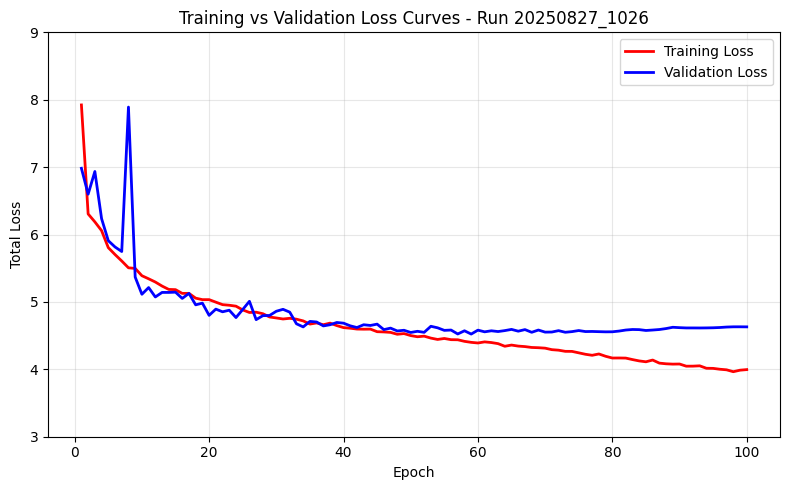

In [59]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

With early stopping (patience=10)

In [60]:
results_path = RUNS_DIR / 'png_runs'  / 'png_aug_bal' / '20250827_1730_685852'

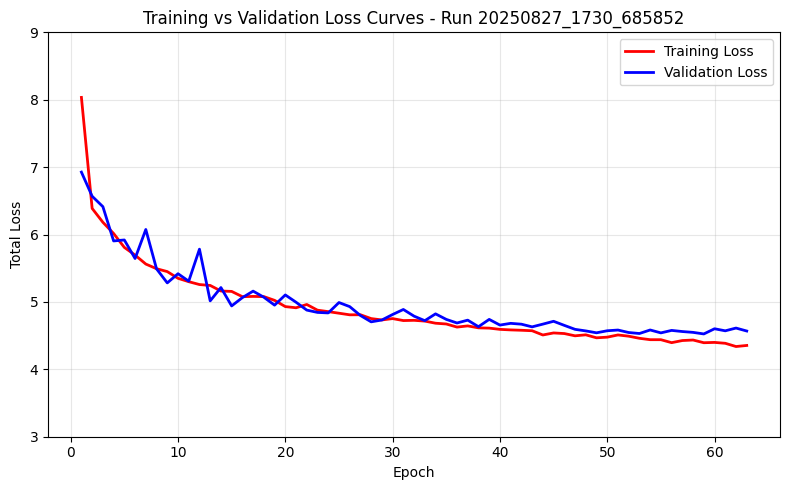

In [61]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

### 3.9 Using Better Balanced Dataset (0.97:1)

Use best training parameters on new better balanced dataset `images_hvrt_msc_bal_new` created 10/09/2025 (single-pol, 2ch: amp + phase + zeros)

In [ ]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_msc_bal_alt_new',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_bal.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [6]:
# Load the model
model = YOLO('yolov8n.pt')

In [ ]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    close_mosaic=0,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_aug_bal',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    patience=10,
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # translation (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

Plot total loss curves:

Duplicate run on Kaya: (single-pol, 2ch: amp + phase + zeros)

In [11]:
results_path = RUNS_DIR / 'png_runs' / 'png_aug_bal' / '20250910_2352_701491'

Plot saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_bal/20250910_2352_701491/loss_plot_20250910_2352_701491.pdf


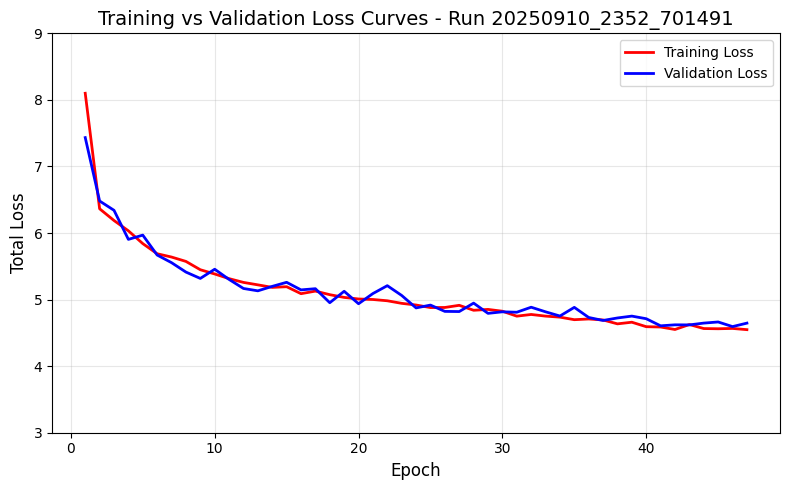

In [12]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9), save_path=str(results_path / 'loss_plot_20250910_2352_701491.pdf'))

### 4.0 Dual Polarisation Processing - no augmentation

Standard (96, 96, 3) PNG images with dual-polarisation processing.

#### 4.1 Unbalanced dataset (3:1) with in situ augmentation only.

In [5]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_png_noaug_dual',
    'val':    'val_dual', 
    'test':   'test_dual',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_noaug_dual.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [6]:
# Load the model
model = YOLO('yolov8n.pt')

In [ ]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    close_mosaic=0,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_runs' / 'png_noaug_dual',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    #patience=10,
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # translation (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

Plot total loss curves:

In [13]:
results_path = RUNS_DIR / 'png_runs' / 'png_noaug_dual' / '20250914_1455_29585' # Run on Kaya2

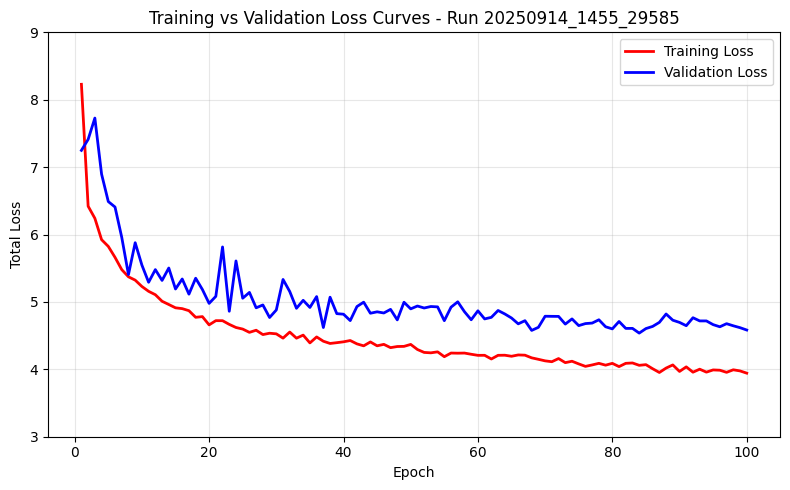

In [11]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

This model's performance metrics match, if not exceed best performing model to date (Run 20250818_1835)!

#### 4.2 Using Better balanced dataset (0.97:1) - pre-augmentaion (hvrt + mosaic) + in situ augmentation (hvrt + mosaic).

In [7]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_msc_bal_dual',
    'val':    'val_dual', 
    'test':   'test_dual',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_dual.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [6]:
# Load the model
model = YOLO('yolov8n.pt')

In [ ]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    close_mosaic=0,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_runs' / 'png_aug_dual',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    #patience=10,
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # translation (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

Plot total loss curves:

In [5]:
results_path = RUNS_DIR / 'png_runs' / 'png_aug_dual' / '20250915_1155_30019' # Run on Kaya2

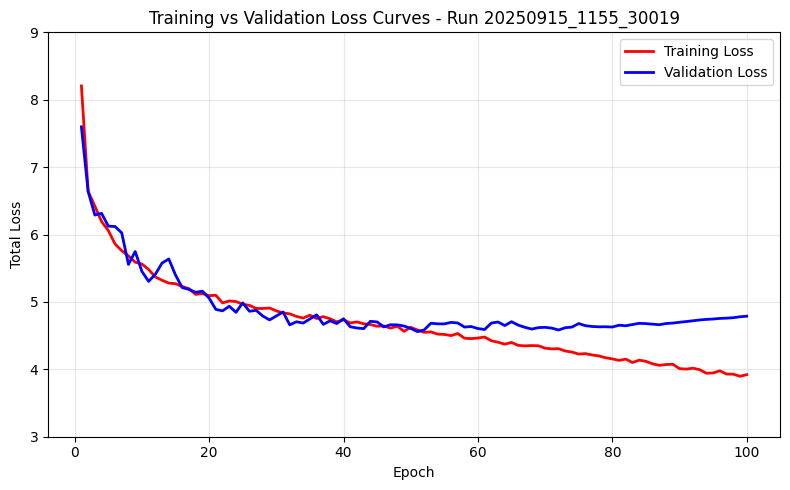

In [6]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

#### 4.3 Using Better balanced dataset (0.97:1) - pre-augmentaion (hvrt + mosaic) + in situ augmentation (hvrt + mosaic) with cos_lr=True & patience=10

In [7]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_msc_bal_dual',
    'val':    'val_dual', 
    'test':   'test_dual',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
yaml_path = CONFIG_DIR / 'png_aug_dual.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

In [6]:
# Load the model
model = YOLO('yolov8n.pt')

In [ ]:
# Create a timestamp for the training run
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# Train the model
results = model.train(
    data=str(yaml_path), 
    epochs=100, 
    batch=16, 
    imgsz=640,
    close_mosaic=0,
    freeze=None,
    plots=True,
    project=RUNS_DIR / 'png_runs' / 'png_aug_dual',
    name=timestamp,
    
    # Optimization
    optimizer='SGD',      # explicit SGD
    lr0=0.01,             # initial learning rate
    lrf=0.01,             # final learning rate factor
    momentum=0.9,         # SGD momentum/Adam beta1
    weight_decay=0.0005,  # optimizer weight decay
    warmup_epochs=3.0,    # warmup epochs
    warmup_momentum=0.8,  # warmup momentum
    warmup_bias_lr=0.1,   # warmup bias lr
    cos_lr=True,
    patience=10,
    
    
    # Augmentation parameters
    auto_augment=None, 
    hsv_h=0.0, 
    hsv_s=0.0, 
    hsv_v=0.0, 
    translate=0.1,  # translation (+/- fraction)
    degrees=15.0,   # rotation (+/- degrees)
    scale=0.0, 
    fliplr=0.5,     # horizontal flip (prob.)
    flipud=0.5,     # vertical flip (prob.)
    mosaic=1.0      # image mosaic (prob.)
)

Plot total loss curves:

In [17]:
results_path = RUNS_DIR / 'png_runs' / 'png_aug_dual' / '20250915_1358_30042' # Run on Kaya2

Plot saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_dual/20250915_1358_30042/loss_plot_20250915_1358_30042.pdf


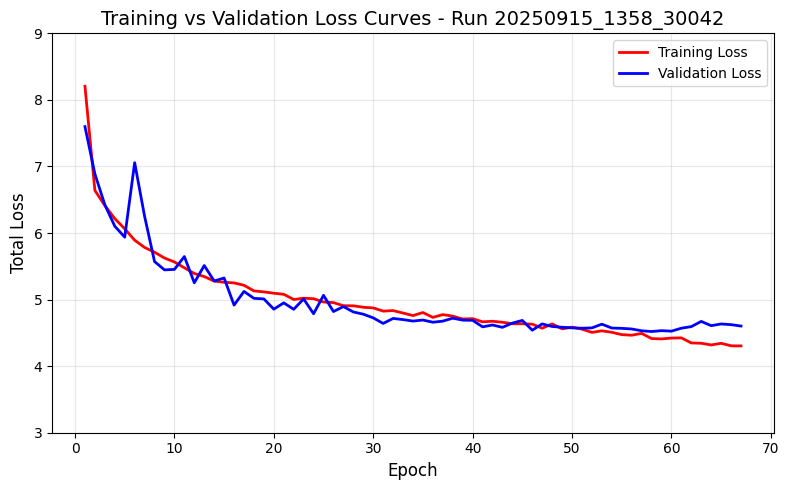

In [18]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9), save_path=str(results_path / 'loss_plot_20250915_1358_30042.pdf'))

This is the best performing model so far.

#### 3.10.4 Using Better balanced dataset (0.98:1) - pre-augmentaion (hvrt + mosaic+ **gf**) + in situ augmentation (hvrt + mosaic) with cos_lr=True & patience=10

In [5]:
results_path = RUNS_DIR / 'png_runs' / 'png_aug_dual' / '20250918_2332_30950' # Run on Kaya2

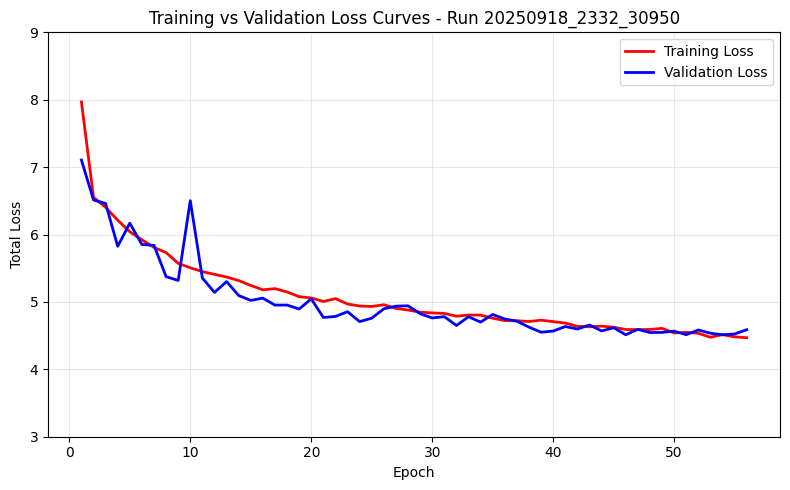

In [6]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9))

This was the extra run conducted for 3-ch single-pol ("_ext" run)

### 5.0 Single-pol 2ch (baseline) re-run with cos_lr=True & patience=10  using Better balanced dataset (0.97:1) - pre-augmentaion (hvrt + mosaic) + in situ augmentation (hvrt + mosaic).

In [15]:
results_path = RUNS_DIR / 'png_runs' / 'png_aug_bal' / '20250924_1934_33064' # Run on Kaya2

Plot saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/png_runs/png_aug_bal/20250924_1934_33064/loss_plot_20250924_1934_33064.pdf


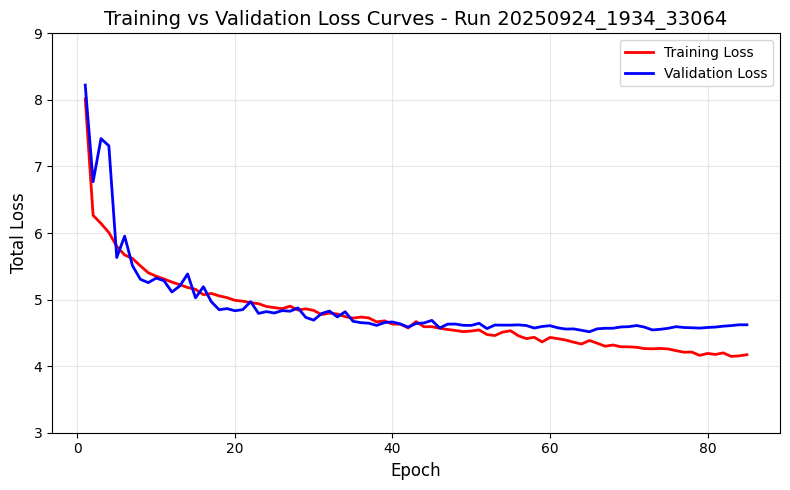

In [16]:
plot_total_loss(str(results_path / 'results.csv'), ylim=(3, 9), save_path=str(results_path / 'loss_plot_20250924_1934_33064.pdf'))